# What is the goal of this analysis?

### The problem
Uber and Lyft are two car-hailing companies that compete for the same clients and partners. Uber aims at increasing partner engagement and fidelity, by making it easier for them to know how to increase daily revenues. 

### The goal
To that end, Uber decided to develop new tools to help drivers better understand how to make each working day more lucrative. The idea is, for any given day, to be able to inform partners of the geographical locations around them and the times of the day where they’re more likely to find rides with higher-than-average profitability, based on the weekday and weather conditions.

# Loading the libraries & specifying preferences

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib as mpl

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Loading the data

#### Create a metric of profitability through a proxy
One negative point about this dataset is that it has no cost variables. That absence impairs the analysis, since obtaining insights to reduce costs and comparing revenues to profit are important iniciatives towards increasing the efficiency of any business.

However, a proxy for fuel consumption can be created. Since longer rides necessarily mean more fuel consumed, a measure of price of the trip per distance (i.e. dollars gained per miles driven) would be a good proxy for profitability. This metric is created here, and the analysis performed later in this document.

Later in the analysis, two regressive models will be developed to predict aggregated revenue and profit based on source location. The dummy variables for the source locations are created here, and the analysis performed later. 

In [32]:
# Changing column names to increase readability
col_names = ['distance','type','timestamp','destination','source','price','multiplier','ride_id','service_id','service_name']
col_names_2 = ['temperature','location','clouds','pressure','rain','timestamp','humidity','wind']

# Loading the .csv files
raw_rides = pd.read_csv('file://localhost/C:/Users/Utilizador/OneDrive/Springboard/Projects/[Diogo Santos] Capstone 2/Data/cab_rides.csv',header=0,names=col_names)
raw_weather = pd.read_csv('file://localhost/C:/Users/Utilizador/OneDrive/Springboard/Projects/[Diogo Santos] Capstone 2/Data/cab_weather.csv',header=0,names=col_names_2)

# Creating a datetime-format timestamp for the rides data, and creating new variables for weekday and hour
raw_rides['timestamp']=pd.to_datetime(raw_rides['timestamp']/1000,unit='s')
raw_rides['date'] = raw_rides['timestamp'].dt.date
raw_rides['time'] = raw_rides['timestamp'].dt.hour
raw_rides['weekday'] = raw_rides['timestamp'].dt.weekday

# Creating a proxy for profitability
raw_rides['dollars per mile'] = raw_rides['price']/raw_rides['distance']

# Creating a datetime-format timestamp for the weather data, and creating new variables for weekday and hour
raw_weather['timestamp']=pd.to_datetime(raw_weather['timestamp'],unit='s')
raw_weather['date'] = raw_weather['timestamp'].dt.date
raw_weather['time'] = raw_weather['timestamp'].dt.hour

# Data Cleansing

### Removing NaN's in the rides dataset
There are 55095 entries in the original rides dataset where price is NA. 

In [33]:
# Revealing the number of NaN's in the rides dataset
print(raw_rides[pd.isna(raw_rides['price'])].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55095 entries, 18 to 693068
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   distance          55095 non-null  float64       
 1   type              55095 non-null  object        
 2   timestamp         55095 non-null  datetime64[ns]
 3   destination       55095 non-null  object        
 4   source            55095 non-null  object        
 5   price             0 non-null      float64       
 6   multiplier        55095 non-null  float64       
 7   ride_id           55095 non-null  object        
 8   service_id        55095 non-null  object        
 9   service_name      55095 non-null  object        
 10  date              55095 non-null  object        
 11  time              55095 non-null  int64         
 12  weekday           55095 non-null  int64         
 13  dollars per mile  0 non-null      float64       
dtypes: datetime64[ns](1)

In [34]:
# In order to clean the dataset before the analysis, NaN entries were removed.
rides_all = raw_rides.dropna()

### Focusing on the target: Uberx and Lyft
This dataset includes rides with every Uber and Lyft service available, including luxury services. However, the focus of this analysis is to obtain insights that help Uber and Lyft partners that provide the regular services - UberX and Lyft.

Therefore, only rides using these two services were retained in the final dataset for anaysis.

In [35]:
# Analysing all services in the dataset
print(rides_all['service_name'].unique())

['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']


In [36]:
# Creating a new dataframe with just the desired services
rides = rides_all[(rides_all['service_name']=='Lyft')|(rides_all['service_name']=='UberX')]
rides.reset_index(drop=True,inplace=True)

# Confirming that only UberX and Lyft remain
print(rides['service_name'].unique())

['Lyft' 'UberX']


# Understanding the data on rides
### Check the distribution of each original numerical variable
To better analyze time differences, two variables were created out of the timestamp: time of the day in the form of one-hour periods, and weekday.

         distance       price  multiplier        time     weekday
count  106329.000  106329.000  106329.000  106329.000  106329.000
mean        2.189       9.691       1.018      11.628       2.788
std         1.135       2.498       0.107       6.949       2.059
min         0.020       5.000       1.000       0.000       0.000
25%         1.270       7.500       1.000       6.000       1.000
50%         2.160       9.500       1.000      12.000       3.000
75%         2.930      10.500       1.000      18.000       5.000
max         7.860      44.000       3.000      23.000       6.000


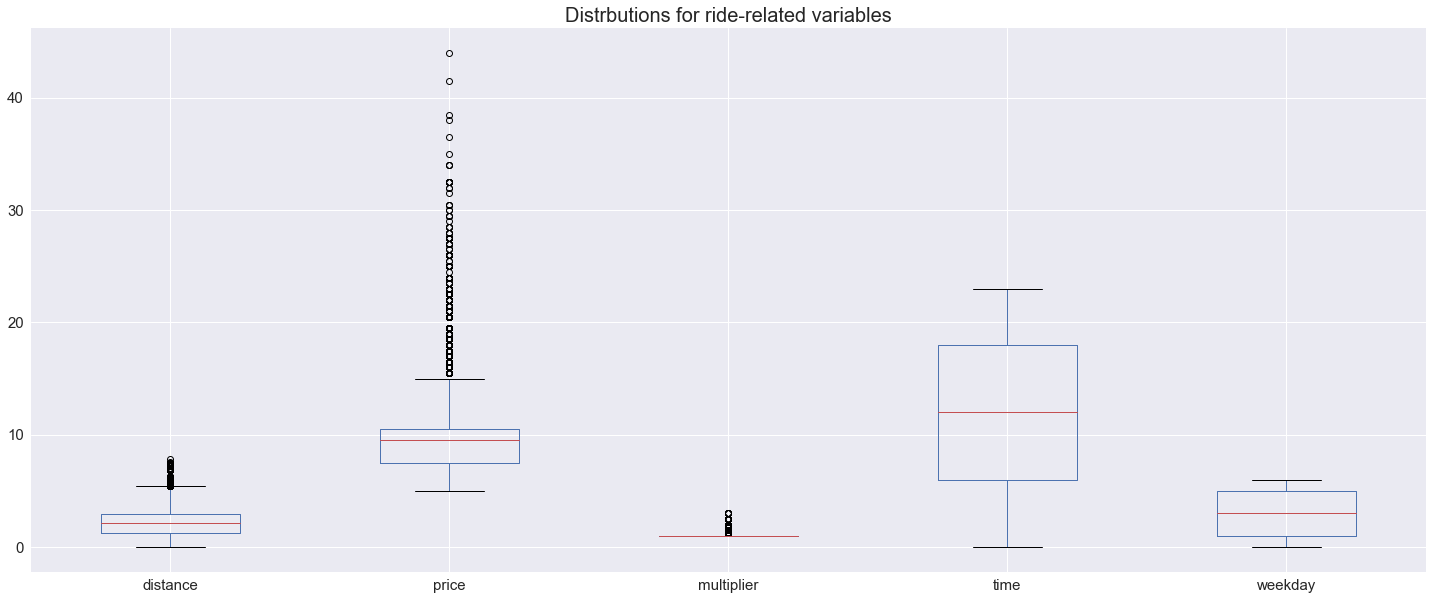

The 1st quartiles are:
distance            1.270
price               7.500
multiplier          1.000
time                6.000
weekday             1.000
dollars per mile    3.618
Name: 0.25, dtype: float64
 
The 3rd quartiles are:
distance             2.930
price               10.500
multiplier           1.000
time                18.000
weekday              5.000
dollars per mile     6.333
Name: 0.75, dtype: float64
 
The IQRs are:
distance             1.660
price                3.000
multiplier           0.000
time                12.000
weekday              4.000
dollars per mile     2.715
dtype: float64
 
The upper limits for outliers are:
distance             5.420
price               15.000
multiplier           1.000
time                36.000
weekday             11.000
dollars per mile    10.406
dtype: float64
 
The lower limits for outliers are:
distance            -1.220
price                3.000
multiplier           1.000
time               -12.000
weekday             -5.000
d

In [37]:
# Creating column for the variables intended
cols =['distance','price','multiplier','time','weekday']

# Observing characteristics of the distribution of the numerical variables for the rides dataframe
print(rides[cols].describe())

# Visualizing the distribution of the same variables
rides[cols].boxplot(figsize=((25,10)),fontsize=15)
plt.title('Distrbutions for ride-related variables',fontsize=20)
plt.style.use('seaborn')
plt.savefig('rides_distribution.png',bbox_inches='tight')

plt.show()

# Creating a function to return the necessary information to remove the outliers    
def iqr(df):
    q1 = df.quantile(.25)
    q3 = df.quantile(.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr
    print('The 1st quartiles are:')
    print(q1)
    print(' ')
    print('The 3rd quartiles are:')
    print(q3)
    print(' ')
    print('The IQRs are:')
    print(iqr)
    print(' ')
    print('The upper limits for outliers are:')
    print(upper_limit)
    print(' ')
    print('The lower limits for outliers are:')
    print(lower_limit)
    print(' ')

# Calculating IQR, as well as upper and lower limits for outliers in case it becomes necessary to remove them
iqr(rides)

### Is it worth removing any outliers? Why?

The variable that immediatly stands out due to its outliers is price of the ride. However, doesn't seem to exist any valid reason to remove those observations since they're well-recorded rides that fit our target group of partners.

Another variable that has a few outliers is distance. It's hipothesized that short rides are the most profitable (which is tested and confirmed later in this analysis), so it could be argued that it's worth removing the distance outliers (which in this case represent longer rides) in order to obtain insights tailored to increase the likelyhood of getting short rides. However, in doing so we run the risk of getting insights that show ways to increase revenues through short rides not because they're simply more profitable, but because we removed the longer rides.

Considering there arguments, no outliers will be removed. Later in this analysis there will be a section focused on analysing a proxy measure of profitability - 'dollars per mile' of the ride. There, we'll see how our insights differ with and without outliers for that specific variable. The reasons for it are explained then.

# How to measure profitability?
As indicated in the Loading Data section, a variable called 'dollars per mile' was created to serve as a metric of profitability of each ride, given the absence of data on costs.

### Distribution of the profitability metric



Description of the variable "dollars per mile", a proxy for ride profitability:

count    106329.000
mean          5.666
std           6.363
min           1.837
25%           3.618
50%           4.600
75%           6.333
max         375.000
Name: dollars per mile, dtype: float64


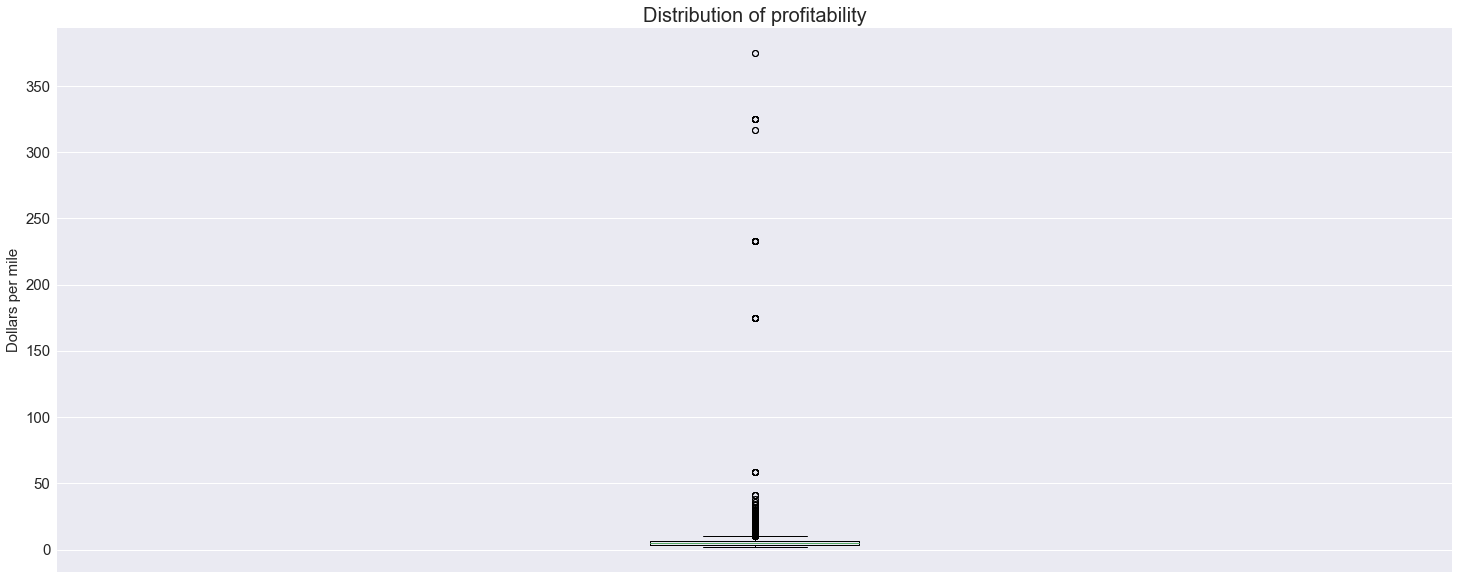

In [38]:
print('')
print('Description of the variable "dollars per mile", a proxy for ride profitability:')
print('')
print(rides['dollars per mile'].describe())

# Plotting the distribution of the proxy for profitability of each ride: dollars per mile
plt.figure(figsize=((25,10)))
plt.title('Distribution of profitability',fontsize=20)
plt.boxplot(rides['dollars per mile'])
plt.xticks([])
plt.yticks(fontsize=15)
plt.ylabel('Dollars per mile',fontsize=15)
plt.savefig('profit_distrib.png',bbox_inches='tight')

plt.style.use('seaborn')
plt.show()

Looking at the distribution of this new metric it's possible to immediatly obtain important informations. We can see that the average ride costs 5.666 dollars/mile, and that the median is 4.6 dollars/mile. 

This difference is easily explained by the outliers, in this case rides with much higher profitabilities than what would be expected (e.g. the maximum value is 375 dollars/mile). 

To understand if there was any faulty recordings of the data that might explain this variable, the next step is looking at these rows, focusing specifically on rides with profitability above 50 dollars/mile.

In [39]:
# creating one variable for the rides with profitability above 50$/mile
profit_outliers = rides[rides['dollars per mile']>50]

# Description of the distribution of the outtliers
print(profit_outliers.describe())

       distance   price  multiplier    time  weekday  dollars per mile
count    67.000  67.000        67.0  67.000   67.000            67.000
mean      0.043   7.030         1.0  12.299    2.642           215.299
std       0.031   0.476         0.0   6.998    2.005            80.030
min       0.020   6.500         1.0   0.000    0.000            58.333
25%       0.030   7.000         1.0   6.000    1.000           175.000
50%       0.030   7.000         1.0  14.000    3.000           233.333
75%       0.040   7.000         1.0  18.000    4.000           233.333
max       0.120   9.500         1.0  23.000    6.000           375.000


In [40]:
# Understanding if there were any luxury services that weren't filtered out that could be inflating prices
print(profit_outliers['service_name'].unique())

['UberX']


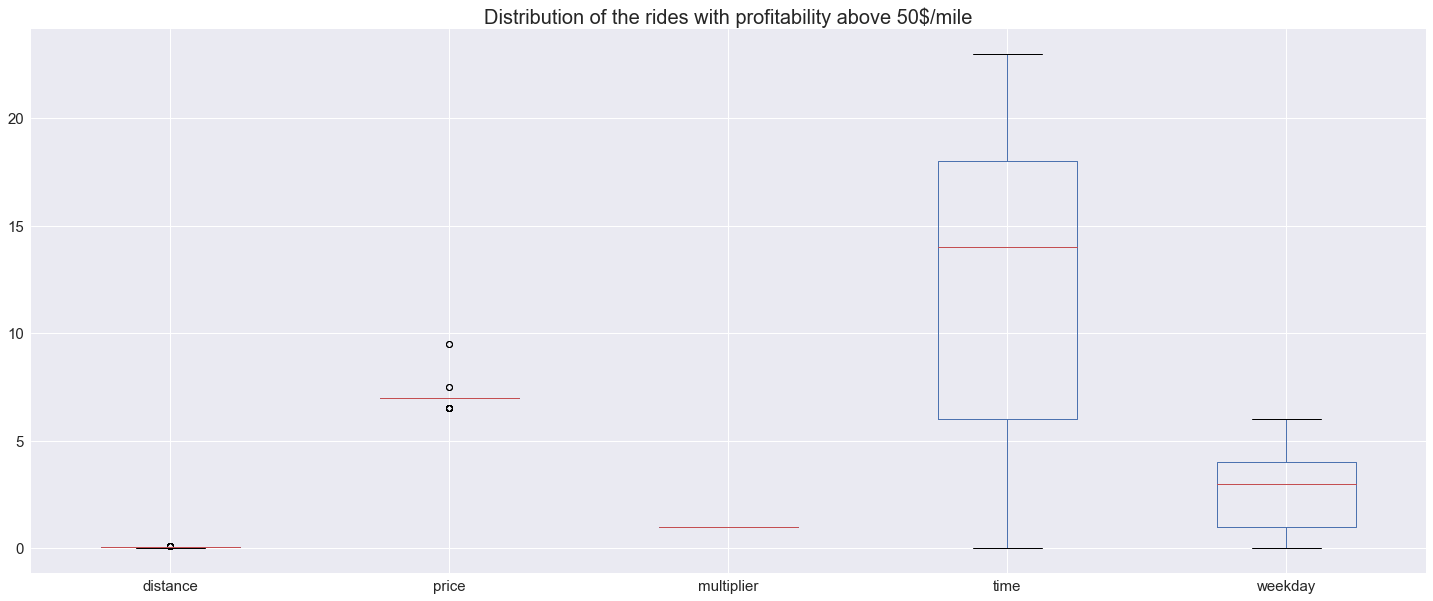

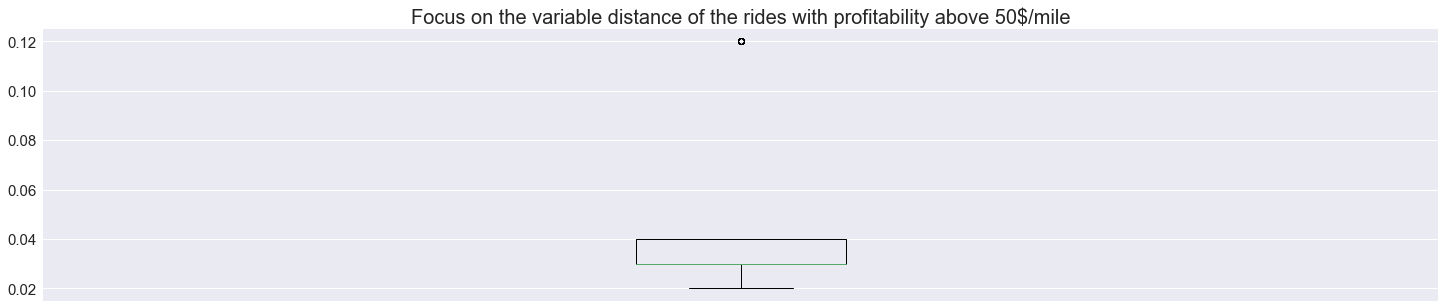

In [77]:
# Plotting the distribution of the outliers of 'dollars per mile'
profit_outliers[cols].boxplot(figsize=((25,10)))
plt.title('Distribution of the rides with profitability above 50$/mile',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('profit_out_distrib.png',bbox_inches='tight')


plt.figure(figsize=((25,5)))
plt.boxplot(profit_outliers['distance'])
plt.xticks([],fontsize=15)
plt.yticks(fontsize=15)
plt.title('Focus on the variable distance of the rides with profitability above 50$/mile',fontsize=20)
plt.savefig('profit_out_dist_distrib.png',bbox_inches='tight')

plt.show()

### Decision: w/ or without outliers?
By looking at this data points, what becomes noticeable is that all those rides were very short in distance. Nothing else out of the ordinary becames apparent that would justify classifiying these entries as faulty in any way. That being the case, there isn't any evident reason to remove these outliers from the data set and the analysis. 

# Goal 1 - Target the locations, times and weekdays with higher demand

## Goal 1A: Analysis of demand per source and destination
One of the goals of this analysis is to understand what are the locations with higher demand. To that end, the following is an analysis if the number of rides in the dataset per source and destination 

In [42]:
source_count = rides.groupby('source')['ride_id'].count()
print('')
print('List of number of rides per source location:')
print('')
print(source_count)


List of number of rides per source location:

source
Back Bay                   8867
Beacon Hill                8807
Boston University          8862
Fenway                     8861
Financial District         9033
Haymarket Square           8858
North End                  8862
North Station              8762
Northeastern University    8860
South Station              8860
Theatre District           8867
West End                   8830
Name: ride_id, dtype: int64


In [43]:
destination_count = rides.groupby('destination')['ride_id'].count()
print('')
print('List of number of rides per destination:')
print('')
print(destination_count)


List of number of rides per destination:

destination
Back Bay                   8865
Beacon Hill                8806
Boston University          8862
Fenway                     8861
Financial District         9032
Haymarket Square           8862
North End                  8860
North Station              8763
Northeastern University    8861
South Station              8860
Theatre District           8865
West End                   8832
Name: ride_id, dtype: int64


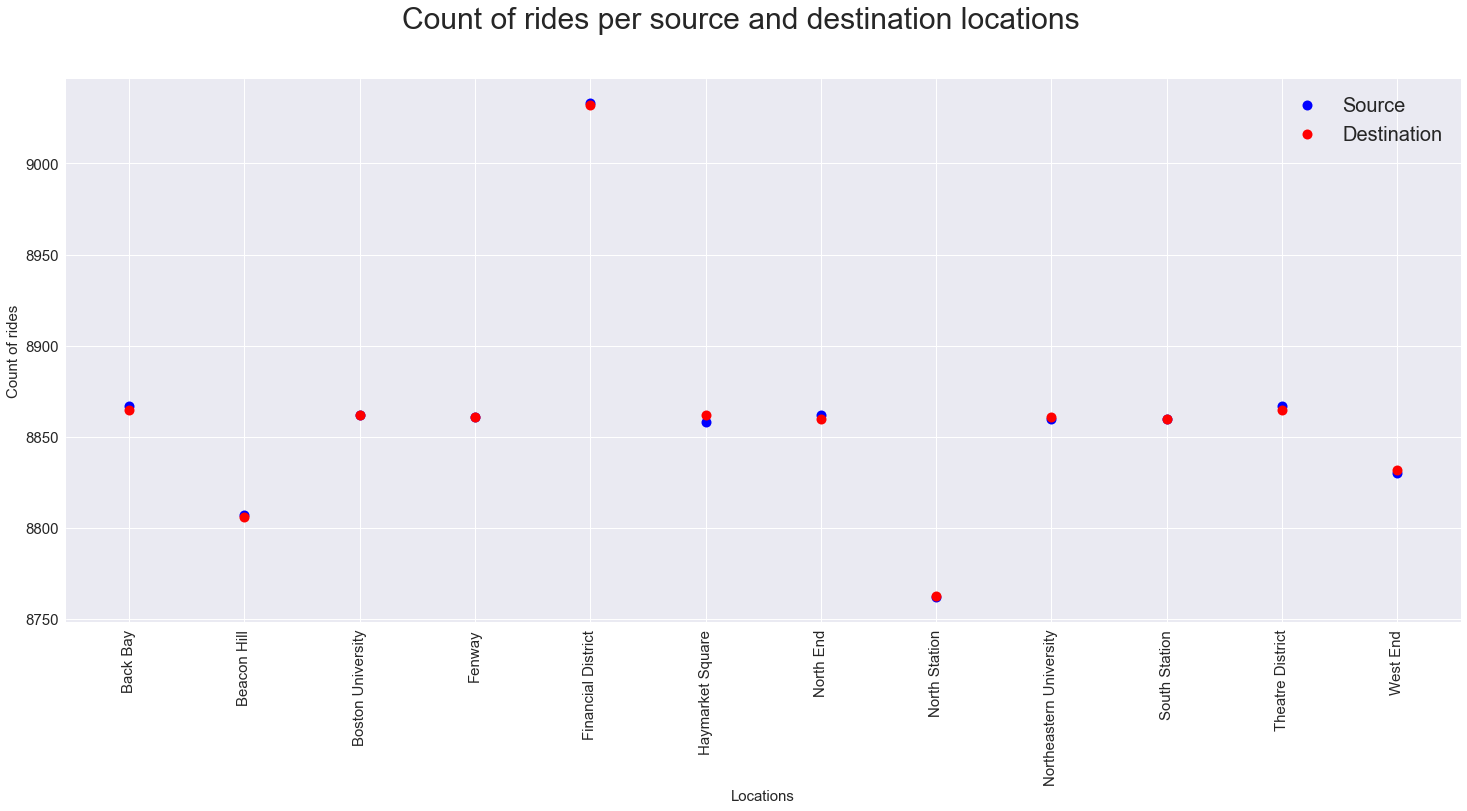

In [78]:
fig,ax = plt.subplots(figsize=((25,10)))
plt.plot(source_count,'blue',label='Source',marker='.',linestyle='none',markersize=20)
plt.plot(destination_count,'red',label='Destination',marker='.',linestyle='none',markersize=20)

fig.suptitle('Count of rides per source and destination locations',fontsize=30)
plt.ylabel('Count of rides',fontsize=15)
plt.xlabel('Locations',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.legend(fancybox=True,fontsize=20)
plt.style.use('seaborn')
plt.savefig('countrides_location.png',bbox_inches='tight')

plt.show()

### Is the number of rides the best metric for demand? Looking into aggregated revenue
Does more demand equal more aggregated revenue? Or are there places where rides are worth more, and therefore can bring more reveneue even with less ride frequency? To answer this questions, is important to analyze how much revenue each location has provided to drivers (i.e. the sum of ride prices for each source and destination locations).

In [45]:
source_sum = rides.groupby('source')['price'].sum()
print('')
print('List of aggregated revenue per source location:')
print('')
print(source_sum)


List of aggregated revenue per source location:

source
Back Bay                   83774.48
Beacon Hill                81898.00
Boston University          97082.00
Fenway                     95545.50
Financial District         95035.85
Haymarket Square           70150.50
North End                  79179.50
North Station              82446.50
Northeastern University    93643.00
South Station              82390.50
Theatre District           86511.00
West End                   82753.85
Name: price, dtype: float64


In [46]:
destination_sum = rides.groupby('destination')['price'].sum()
print('')
print('List of aggregated revenue per destination:')
print('')
print(destination_sum)


List of aggregated revenue per destination:

destination
Back Bay                   84151.00
Beacon Hill                85359.00
Boston University          97712.50
Fenway                     93930.50
Financial District         96306.00
Haymarket Square           73773.85
North End                  77334.00
North Station              85387.00
Northeastern University    92634.48
South Station              77034.35
Theatre District           83732.00
West End                   83056.00
Name: price, dtype: float64


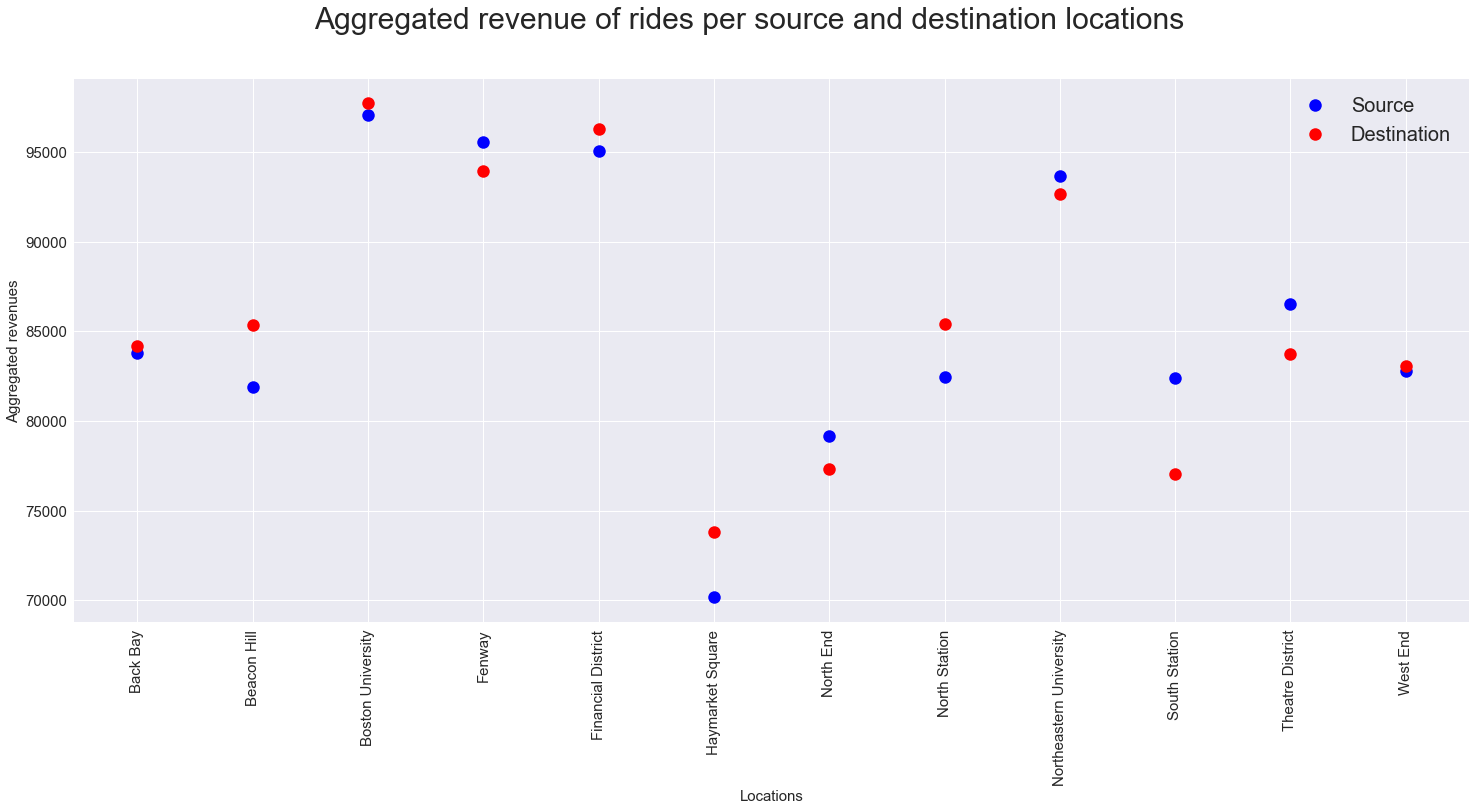

In [79]:
fig,ax = plt.subplots(figsize=((25,10)))
plt.plot(source_sum,'blue',label='Source',marker='.',linestyle='none',markersize=25)
plt.plot(destination_sum,'red',label='Destination',marker='.',linestyle='none',markersize=25)

fig.suptitle('Aggregated revenue of rides per source and destination locations',fontsize=30)
plt.ylabel('Aggregated revenues',fontsize=15)
plt.xlabel('Locations',fontsize=15)
plt.legend(fancybox=True,fontsize=20)
plt.style.use('seaborn')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.savefig('aggrev_locations.png',bbox_inches='tight')

plt.show()

#### Insights on demand per source and destination location - comparing number of rides to aggregated revenue

The results above make it clear that the locations which bring in the most revenue are not necessarily the ones with higher demand. While 'Financial District' is clearly the place where more rides start and end (9033 and 9032, respectively), 'Boston University' is the location that generated more aggregated revenues - 97082 dollars as source, and 97712 dollars as destination (followed closely by 'Financial District', 'Fenway' and 'Northwestern University').

On the other hand, 'North Station' is clearly the location with the lowest demand (8762 as source, 8763 as destination) although it provides close to average levels of aggregated revenue. 'Haymarket Square' is the location that brings the least amount of aggregated revenue (70150 as source, 73773 as destination).

One other important note is that although most locations perform similarly in terms of demand (except for 'Financial District' on the positive side, and 'North Station' on the negative side), the pattern of aggregated revenue across locations is much more heterogeneous.

## Goal 1B: Analysis of demand per time - time of day and weekday
Another goal of this analysis is to understand which are the times of the day and of the week with more demand.

The above analysis of demand per location showed us that looking at the number of rides can provide a very different picture than looking at the aggregated revenues. Therefore, both analysis will be performed for time of day and weekday.

One important note: the creator of the dataset didn't consider this to be a time-series problem, so there were no measures taken to assure regular time intervals.

### Analysis of demand per one-hour periods

In [48]:
time_count = rides.groupby('time')['ride_id'].count()
time_sum = rides.groupby('time')['price'].sum()

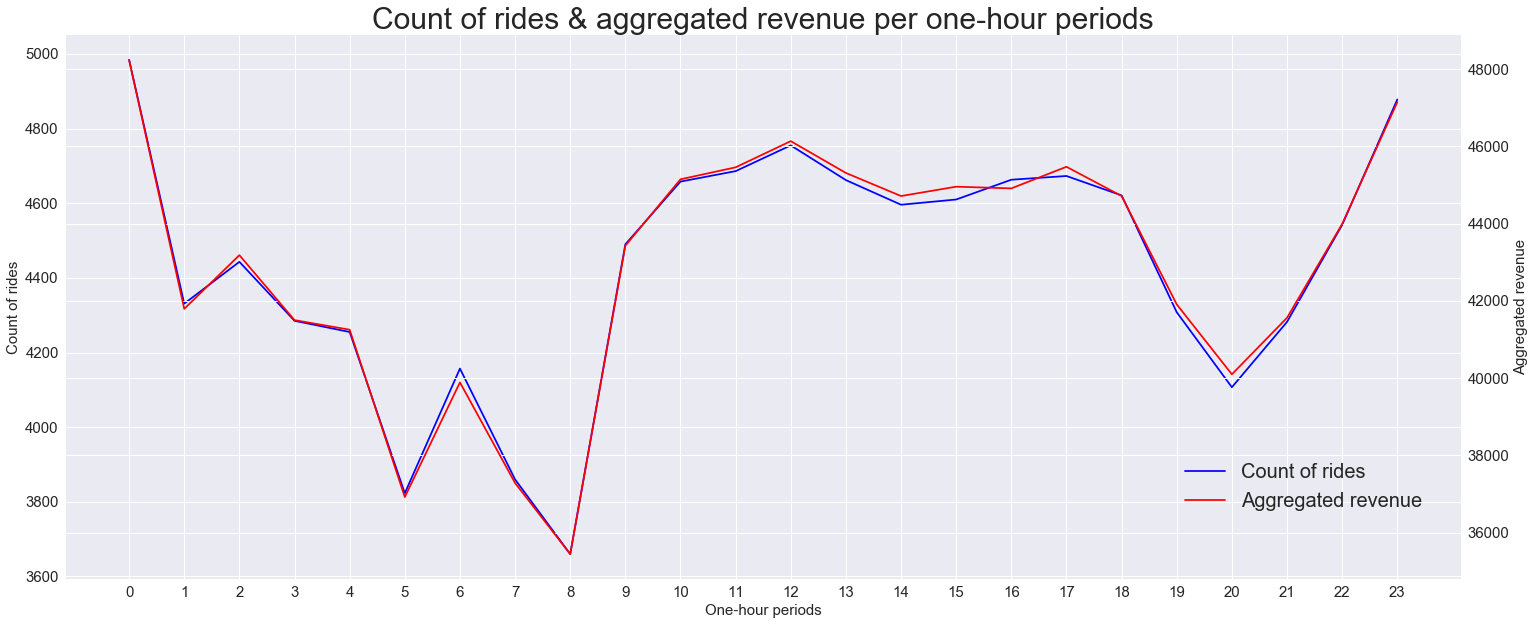

In [80]:
fig,ax1 = plt.subplots(figsize=((25,10)))
plt.plot(time_count,'blue',label='Count of rides')
plt.title('Count of rides & aggregated revenue per one-hour periods',fontsize=30)
plt.ylabel('Count of rides',fontsize=15)
plt.xlabel('One-hour periods',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(0,24,1),fontsize=15)

ax2 = ax1.twinx()
plt.plot(time_sum,'red',label='Aggregated revenue')
plt.ylabel('Aggregated revenue',fontsize=15)
plt.style.use('seaborn')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig('countrides_aggrev_hours.png',bbox_inches='tight')
fig.legend(bbox_to_anchor=(0.8,0.25),fancybox=True,fontsize=20)
plt.show()

### Analysis of demand per weekday
As stated above, looking at the number of rides can provide a very different picture than looking at the aggregated revenues. Therefore, both analysis will be performed for time of day.

In [50]:
weekday_count = rides.groupby('weekday')['ride_id'].count()
print('')
print('List of number of rides per weekday:')
print('')
print(weekday_count)


List of number of rides per weekday:

weekday
0    19028
1    19090
2    11344
3    14966
4    13845
5    13972
6    14084
Name: ride_id, dtype: int64


In [51]:
weekday_sum = rides.groupby('weekday')['price'].sum()
print('')
print('List of aggregated revenue per weekday:')
print('')
print(weekday_sum)


List of aggregated revenue per weekday:

weekday
0    184284.50
1    185112.35
2    110149.00
3    145130.98
4    134129.85
5    135123.50
6    136480.50
Name: price, dtype: float64


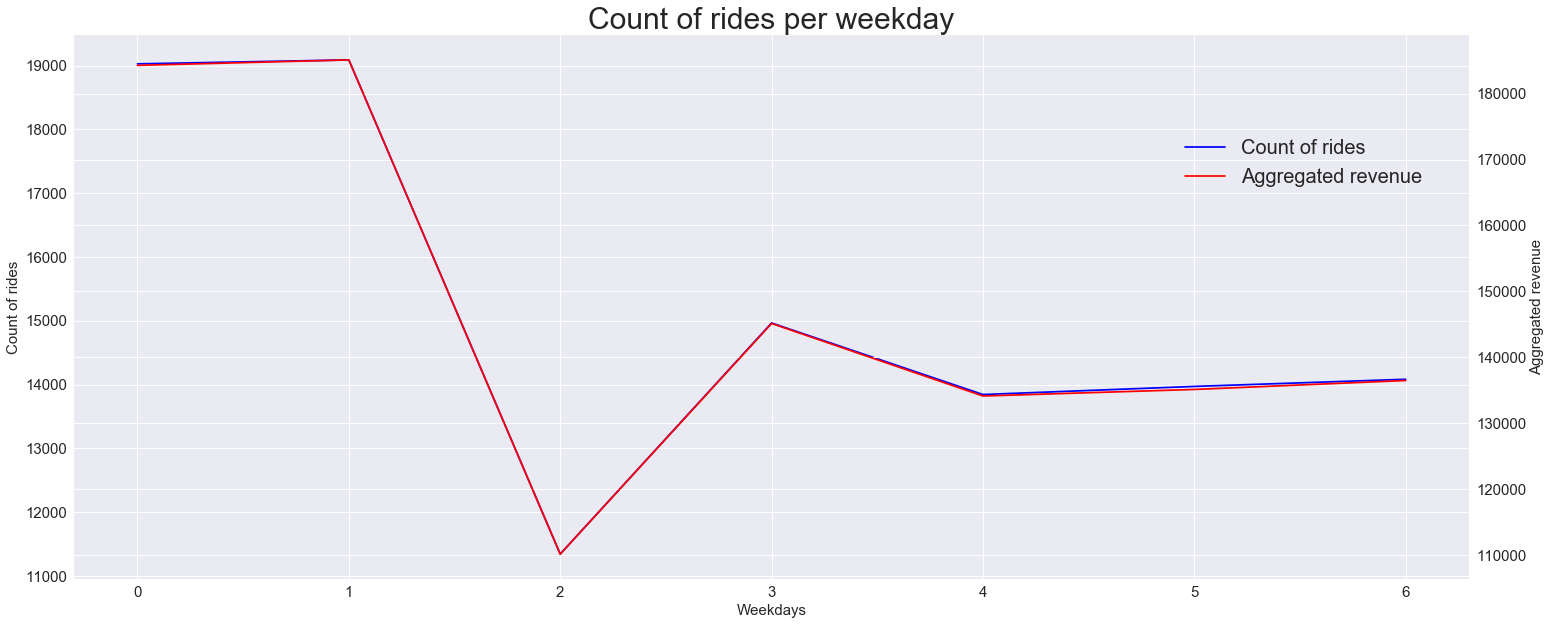

In [81]:
fig,ax1 = plt.subplots(figsize=((25,10)))
plt.plot(weekday_count,'blue',label='Count of rides')
plt.title('Count of rides per weekday',fontsize=30)
plt.ylabel('Count of rides',fontsize=15)
plt.xlabel('Weekdays',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax2 = ax1.twinx()
plt.plot(weekday_sum,'red',label='Aggregated revenue')
plt.ylabel('Aggregated revenue',fontsize=15)
plt.style.use('seaborn')
plt.yticks(fontsize=15)

plt.savefig('countrides_aggrev_weekday.png',bbox_inches='tight')
fig.legend(bbox_to_anchor=(0.8,0.7),fancybox=True,fontsize=20)
plt.show()

#### Insights on demand per time

An immediate insight that can be taken from the analysis is that, unlike location, there is no difference between demand and amount of revenue either at the one-hour-level, or the weekday-level.

Regarding time of the day, there is clearly two periods where demand and revenue are highest. One is between 9am and 6pm, with peaks at midday and 5pm. The second period is between 10pm and 1am, with a peak of demand at midnight.

As for weekday analysis, the data shows that monday and tuesdays are clearly the days when there's dome demand for Uber and Lyft rides. On the other hand, wednesday is the day with less demand in the whole week. 

# Goal 2 - Targeting the most profitable locations, times and weekdays
The goal of this analysis is to understand in the obtained when looking at revenues and demand still hold if we consider the proxy for profitability as a metric.

Regarding location, the following analysis focuses on source only. Since Uber and Lyft partners will not benefit from refusing rides, no insights and recommendations can actually be drawn from analysing how profitable each destination is.

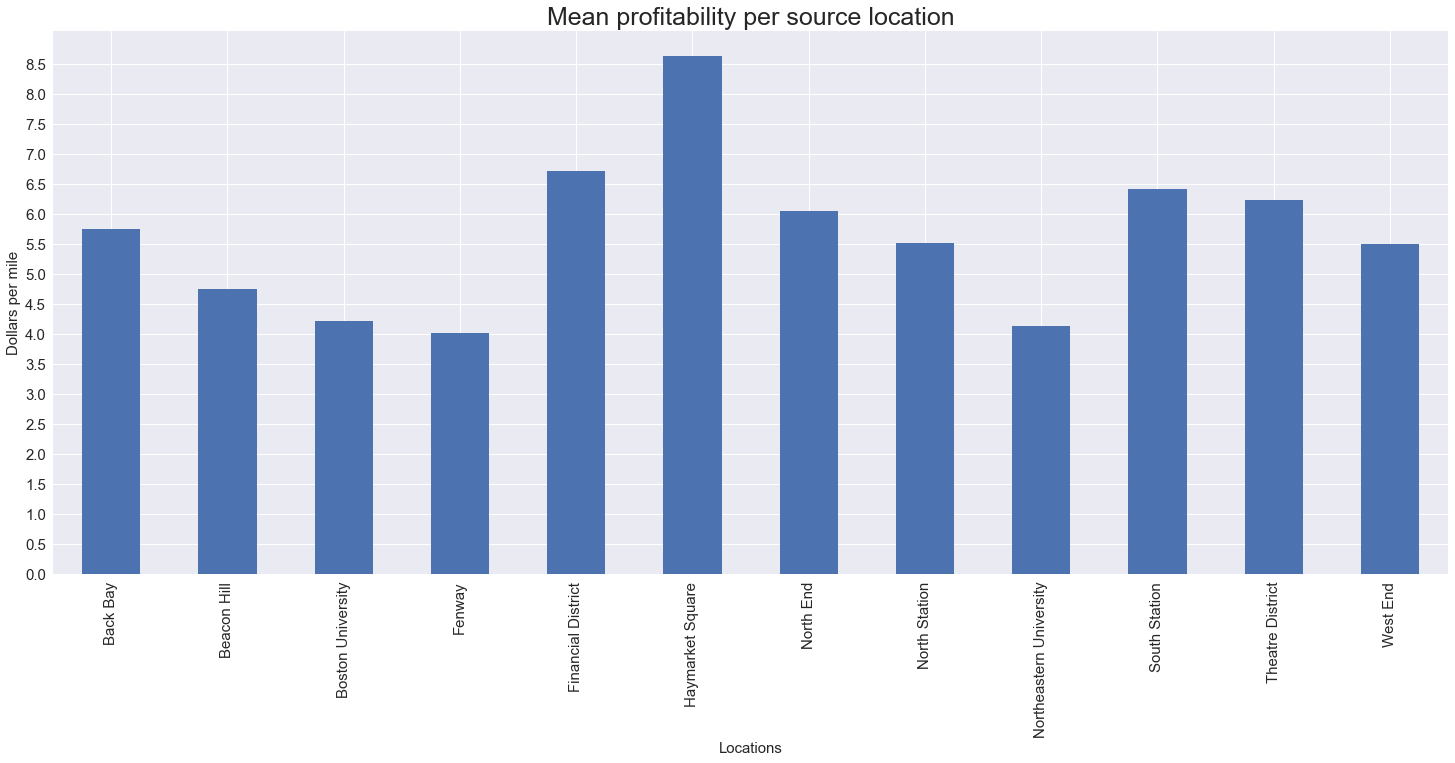

In [82]:
# Grouping profitability by source location of the ride
source_profitability = rides.groupby('source')['dollars per mile'].mean()

#Plotting profitability per source location
plt.figure(figsize=((25,10)))
source_profitability.plot.bar()
plt.title('Mean profitability per source location',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('Locations',fontsize=15)
plt.style.use('seaborn')
plt.yticks(np.arange(0,9,0.5),fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.savefig('profit_locations.png',bbox_inches='tight')

plt.show()

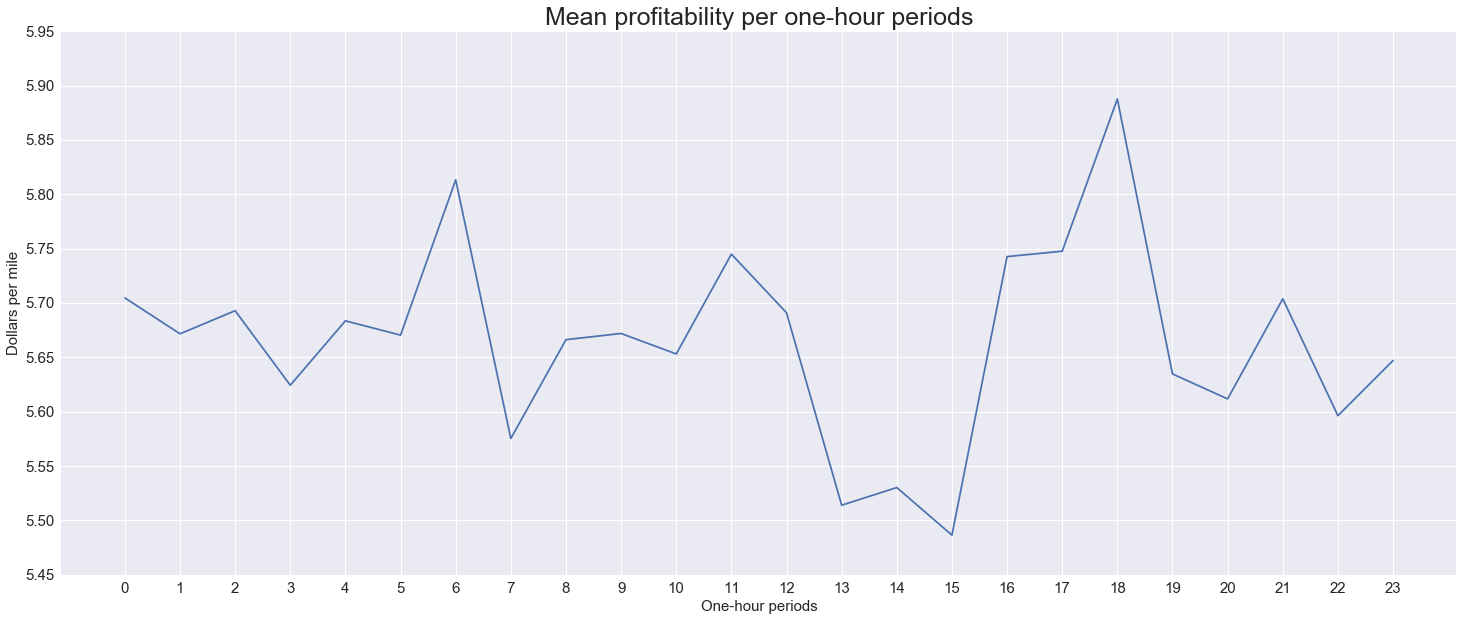

In [83]:
# Grouping profitability by time of the day 
hour_profitability = rides.groupby('time')['dollars per mile'].mean()

# Plotting profitability by time of the day
plt.figure(figsize=((25,10)))
hour_profitability.plot()
plt.title('Mean profitability per one-hour periods',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('One-hour periods',fontsize=15)
plt.style.use('seaborn')
plt.yticks(np.arange(5.45,6,0.05),fontsize=15)
plt.xticks(np.arange(0,24,1),fontsize=15)
plt.savefig('profit_hour.png',bbox_inches='tight')

plt.show()

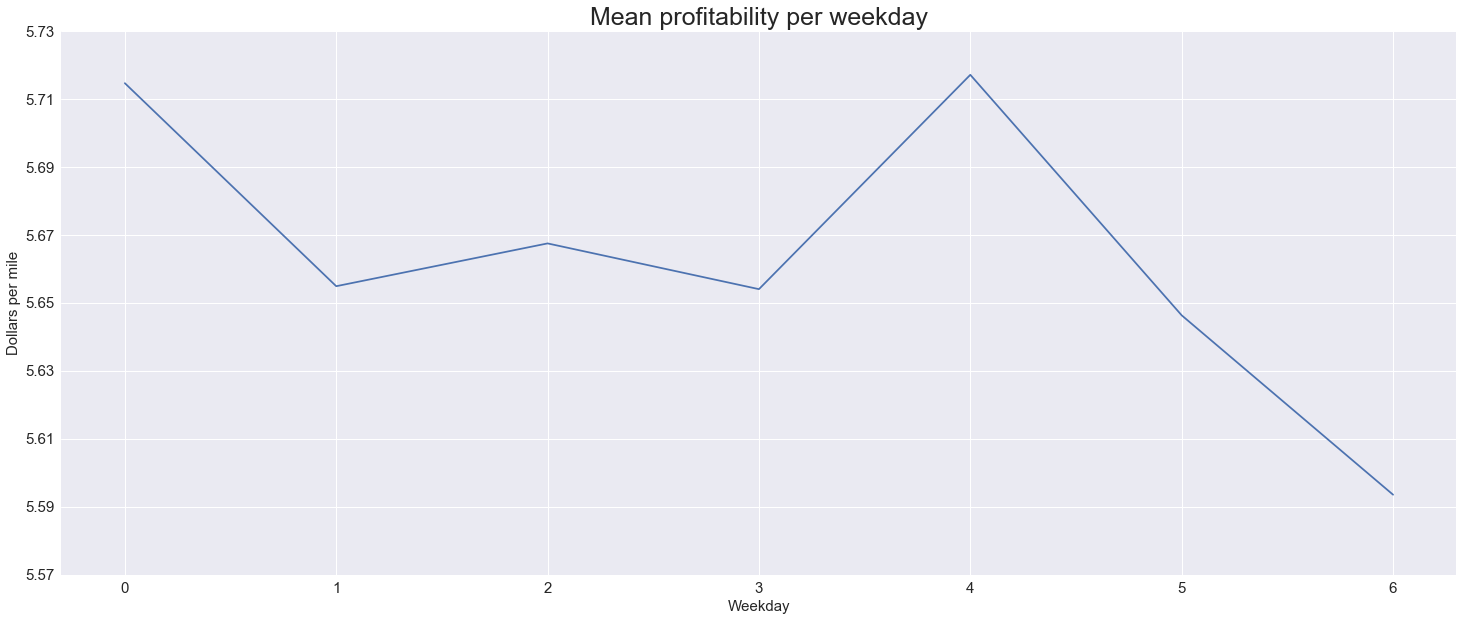

In [84]:
# Grouping profitability by weekday
weekday_profitability = rides.groupby('weekday')['dollars per mile'].mean()

# Plotting profitability by weekday
plt.figure(figsize=((25,10)))
weekday_profitability.plot()
plt.title('Mean profitability per weekday',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('Weekday',fontsize=15)
plt.style.use('seaborn')
plt.yticks(np.arange(5.57,5.75,0.02),fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('profit_weekday.png',bbox_inches='tight')

plt.show()

#### Insights on profitability per location, time & weekday
The above analysis challenges the insights obtained when considering how revenenue varies with time and location.

Regarding source location, 'Haymarket Square' stands out as the place with the highest average profitability - 8.62 dollars/mile. That means that this is the location where rides with higher profitability tend to start. This stands in stark contrast with source locations that generated the most revenue: 'Boston University', 'Financial District', 'Fenway' and 'Northwestern University'. In fact, 'Fenway' (4.02 dollars/mile), 'Boston university' (4.22 dollars/mile) and 'Northweastern University' (4.13 dollars/mile) seem to be the places with lower average profitability. Unlike time of the day and weekday, there is a large variability between the profitability of each location (max: 8.62 dollars/mile, min: 4.02 dollars/mile), which indicates that source location is a very relevant criteria to have under consideration when maximizing profits for Uber and Lyft rides.

As for time of the day, the one-hour time slot when average profitability is the highest is at 6pm, followed by 6am. Unlike the pattern for the sum of revenues, there is no period when the value of rides is constant. The period between 1pm and 3pm is clearly the least profitable. However, it's worth mentioning that, unlike the pattern for source location, the variability of average profitability across time of day is small, ranging between 5.49 dollars/mile and 5.89 dollars/mile, so the differences between time periods may not be relevant.

As for weekday, the days with the highest averages of are monday and friday, when rides average around 5.72 dollars/mile. The day with the lowest average is Sunday, with 5.59 dollars/mile. Once more, the variability of profitability according to weekday is very small, and so differences between weekdays might not be relevant.

### Would the analysis of profitability be different without outliers?
As stated before, there seem to exist no reason to remove the outliers for profitability based on the quality of the data.

However, rides between 0.2 and 0.12 miles long are not the norm, and do not represent the typology of rides that is being analysed. Therefore, it is of interest to understand if these entries are significantlly afecting our results. To that end, the anaysis of profitability according to location and time will be repeated with the outliers removed, to check for any invalidations of the insights drawn.

In [56]:
# Calculating Q1, Q3 and IQR and getting the outlier bounds
iqr(rides)

The 1st quartiles are:
distance            1.270
price               7.500
multiplier          1.000
time                6.000
weekday             1.000
dollars per mile    3.618
Name: 0.25, dtype: float64
 
The 3rd quartiles are:
distance             2.930
price               10.500
multiplier           1.000
time                18.000
weekday              5.000
dollars per mile     6.333
Name: 0.75, dtype: float64
 
The IQRs are:
distance             1.660
price                3.000
multiplier           0.000
time                12.000
weekday              4.000
dollars per mile     2.715
dtype: float64
 
The upper limits for outliers are:
distance             5.420
price               15.000
multiplier           1.000
time                36.000
weekday             11.000
dollars per mile    10.406
dtype: float64
 
The lower limits for outliers are:
distance            -1.220
price                3.000
multiplier           1.000
time               -12.000
weekday             -5.000
d

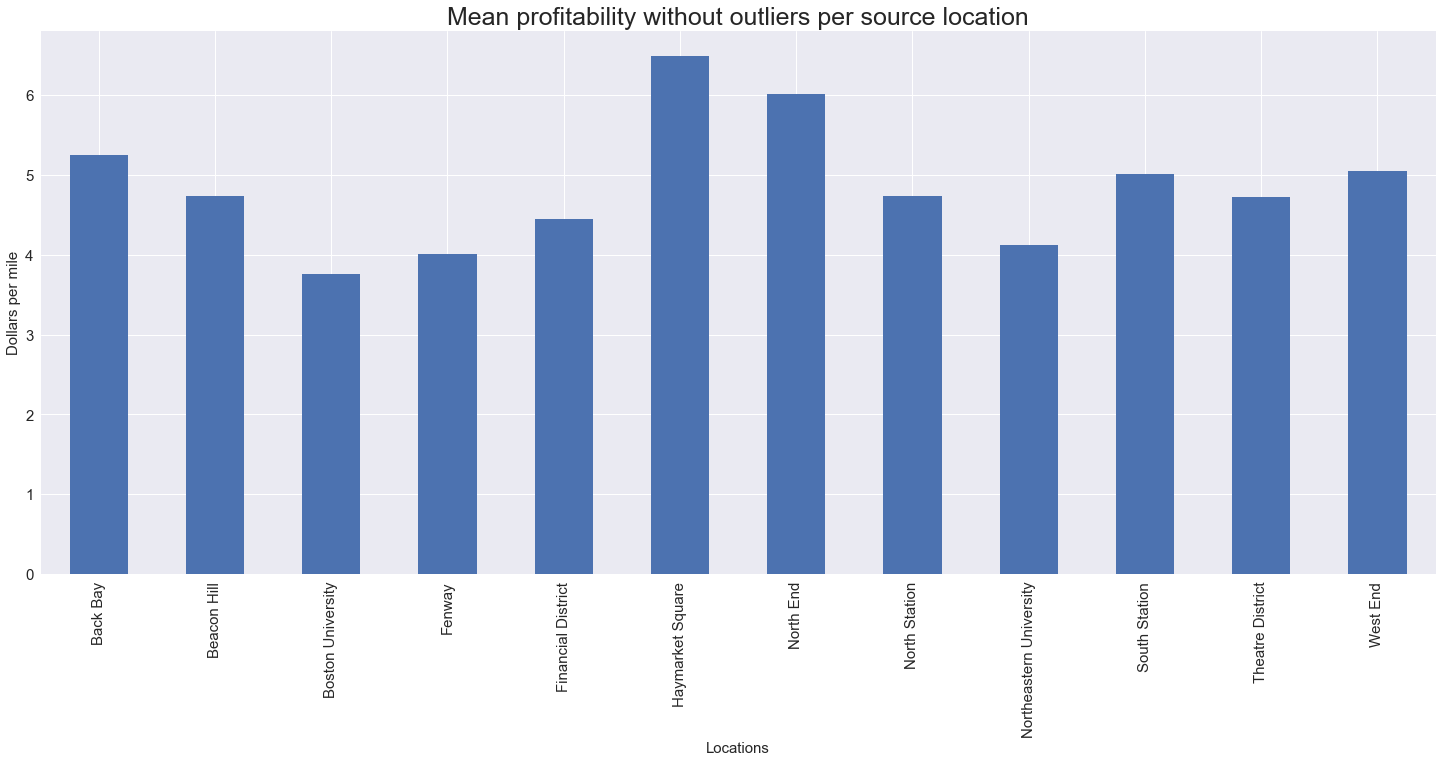

In [57]:
# Creating the new variable
rides_profit = rides[(rides['dollars per mile']>=-0.454)&(rides['dollars per mile']<=10.406)]

# Grouping profitability without outliers by source location of each ride
source_profitability_no_out = rides_profit.groupby('source')['dollars per mile'].mean()

# Plotting profitability without outliers per source
plt.figure(figsize=((25,10)))
source_profitability_no_out.plot.bar()
plt.title('Mean profitability without outliers per source location',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('Locations',fontsize=15)
plt.style.use('seaborn')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)

plt.show()

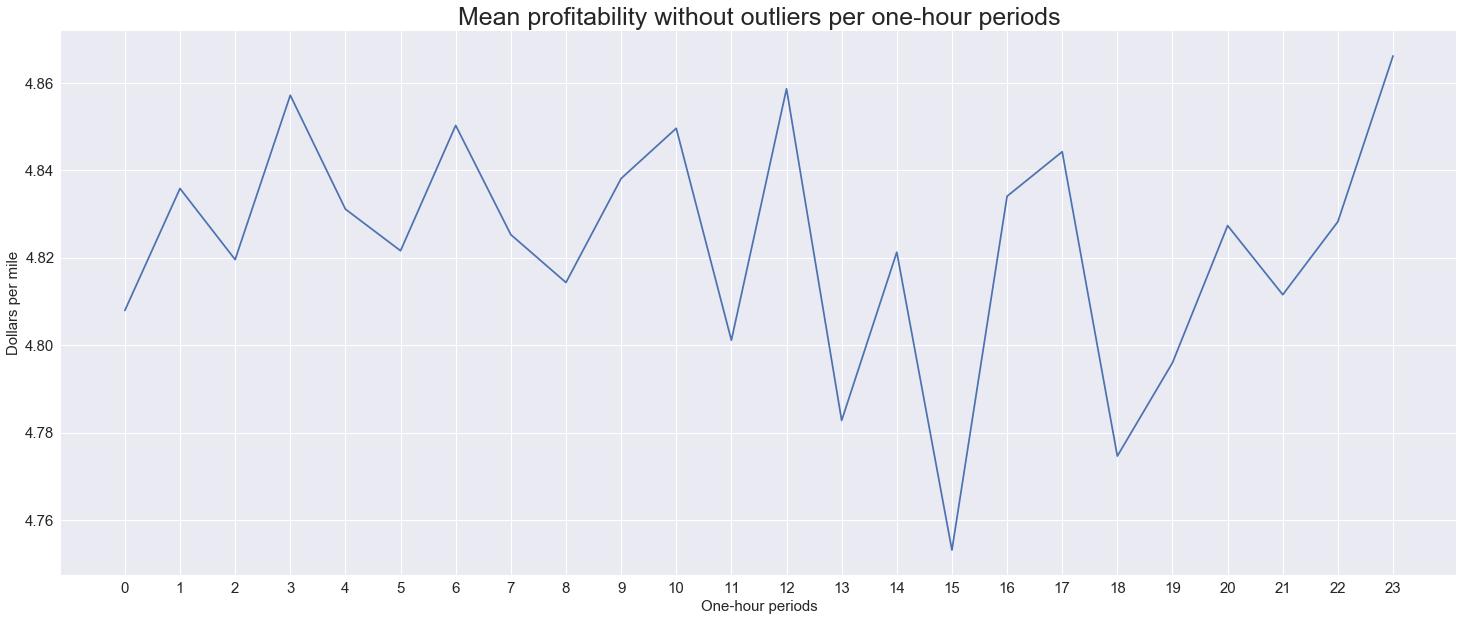

In [58]:
# Grouping profitability without outliers by time of the day
hour_profitability_no_out = rides_profit.groupby('time')['dollars per mile'].mean()

# Plotting profitability without outliers by time of the day
plt.figure(figsize=((25,10)))
hour_profitability_no_out.plot()
plt.title('Mean profitability without outliers per one-hour periods',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('One-hour periods',fontsize=15)
plt.style.use('seaborn')
plt.yticks(fontsize=15)
plt.xticks(np.arange(0,24,1),fontsize=15)

plt.show()

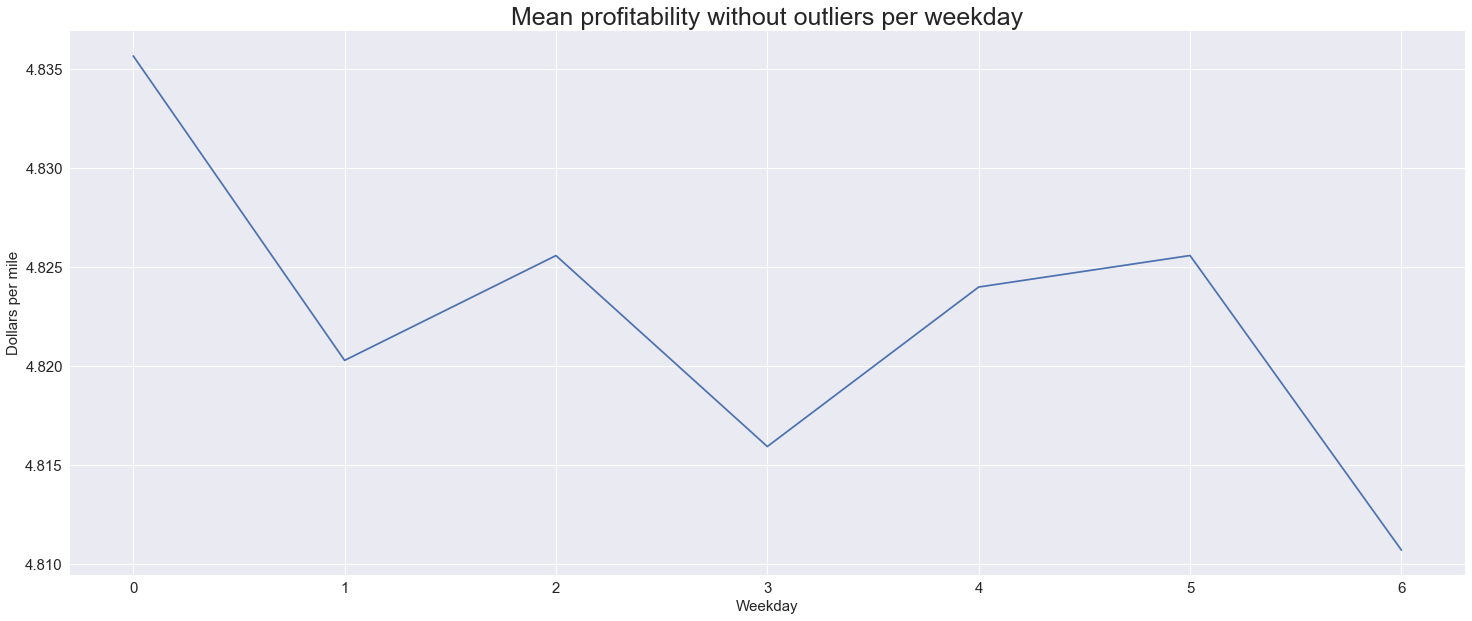

In [59]:
# Grouping profitability without outliers by weekday
weekday_profitability_no_out = rides_profit.groupby('weekday')['dollars per mile'].mean()

# Plotting profitability without outliers by weekday
plt.figure(figsize=((25,10)))
weekday_profitability_no_out.plot()
plt.title('Mean profitability without outliers per weekday',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('Weekday',fontsize=15)
plt.style.use('seaborn')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()

#### Insights on profitability vs location, time & weekday - analysis without outliers

Removing the outliers of the proxy for profitability appears to have only altered slightly the patterns of profitability according to source location, time of day and weekday.

Regarding source location, 'Haymarket Square' is still the most profitable source location (6.48 dollars/mile), but it's now closely followed by 'North End' (6.01 dollars/mile). 'Fenway' (4.02 dollars/mile), 'Boston university' (3.76 dollars/mile) and 'Northweastern University' (4.12 dollars/mile) are still the least profitable. One important change is that the variability between the profitability of each location is reduced without the outliers (max:6.01 dollars/mile, min: 3.76 dollars/mile), which speaks for the influence of those outliers. Nonetheless, source location still seems to be a very relevant criteria to maximize profitability.

As for time of the day, without the outliers the peak is at 11pm (4.75 dollars/mile) and lowest point at 3pm (4.87 dollars/mile). However, the variability is now even more reduced, which reinforces the idea that the differences between profitability according to time of the day are not relevant.

As for weekday, the differences are minimal. The peak is still monday (4.84 dollars/mile) and the lowest point is still sunday (4.81 dollars/mile), however the variability is now even more reduced (it's at the second decimal point only), which, as for hour of the day, reinforces that this is not a relevant criteria for profitability.

# Side note: are shorter rides more profitability than longer ones? Settling the differences between demand and profitability
Previously, it was mentioned an hypothesis that longer rides are less profitable that shorter rides. Later, it was made clear that demand (wether measured though count of rides or aggregated revenues) visibly differed from profitability on location, time of the day and weekday. One explanation for that is if distance (and therefore costs for the drivers) don't have a linear relationship with price, which would be the case if shorter rides were more profitable than longer rides. 

The following analysis intends to test that hypothesis. Just as it was did above, the analysis will be repeated with and without the outliers of the profitability variable. 

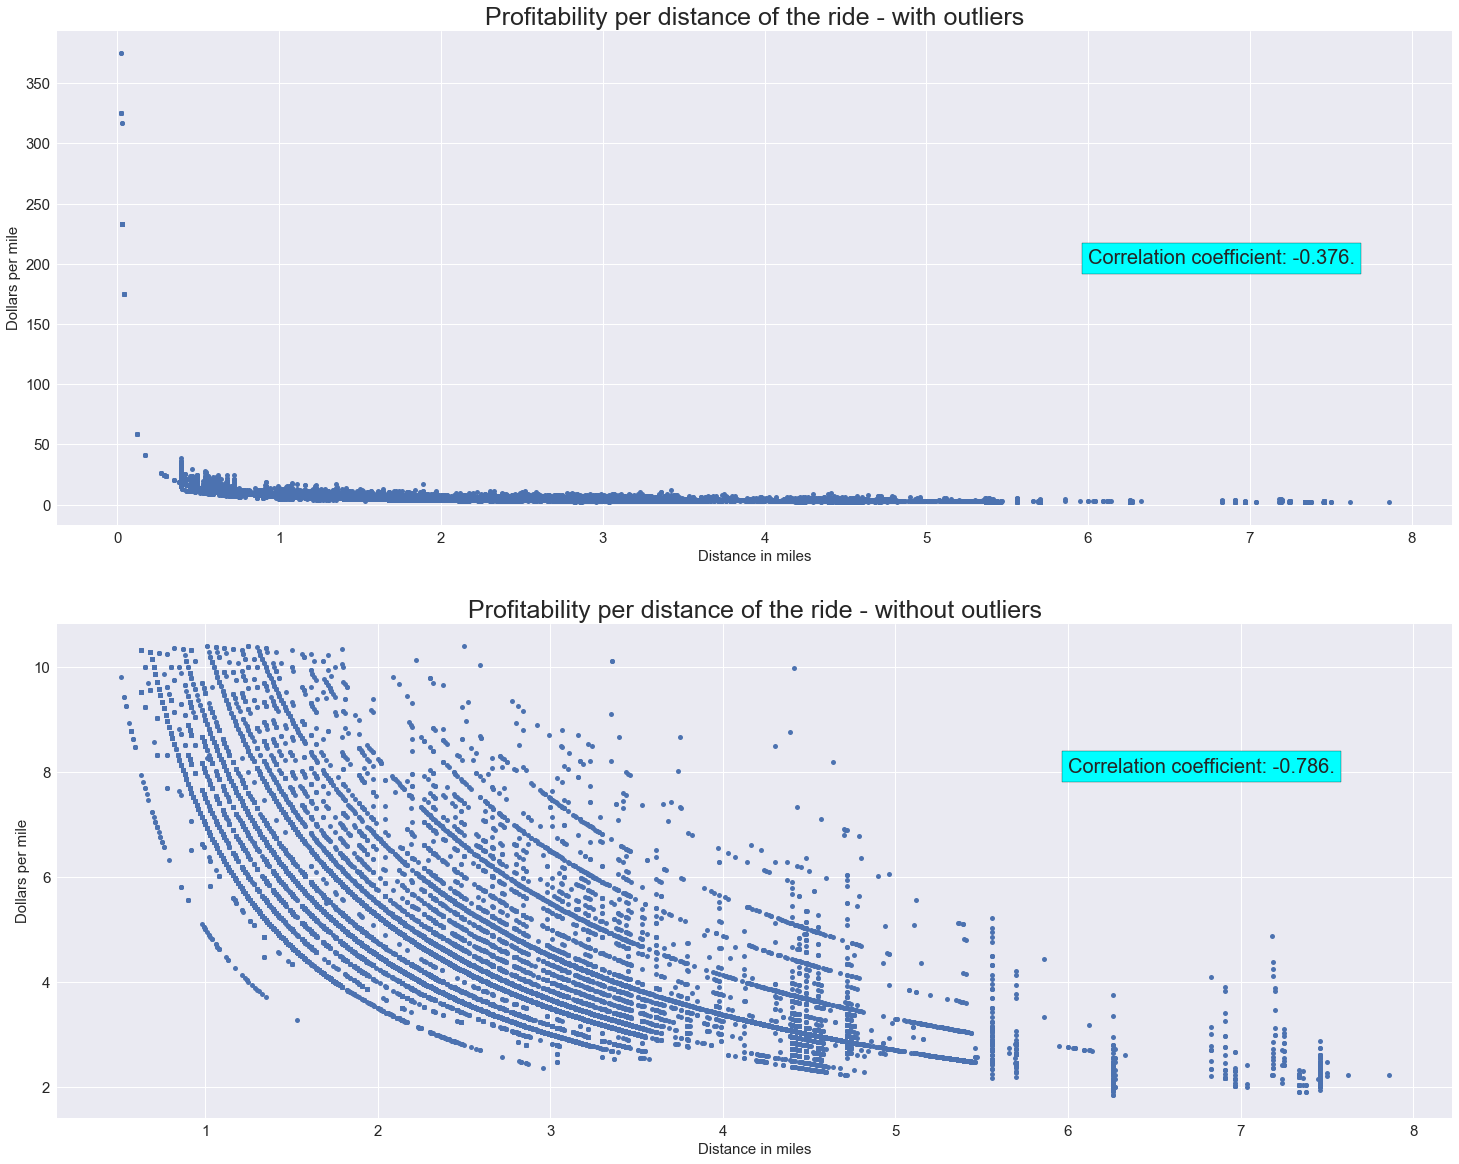

In [87]:
# Calculation correlation between profitability with the outliers and distance of the rides
corr_a = rides['distance'].corr(rides['dollars per mile']).round(3)

# Calculation correlation between profitability without the outliers and distance of the rides
corr_b = rides_profit['distance'].corr(rides_profit['dollars per mile']).round(3)

plt.figure(figsize=((25,20)))

# Plotting profitability with the outliers against the distance of the rides
plt.subplot(2,1,1)
plt.plot(rides['distance'],rides['dollars per mile'],marker='.',linestyle='none',markersize=10)
plt.title('Profitability per distance of the ride - with outliers',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('Distance in miles',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.text(6,200,'Correlation coefficient: '+str(corr_a)+'.',fontsize=20,bbox=dict(boxstyle="square,pad=0.3",fc="cyan"))
plt.savefig('profit_dist_corr.png',bbox_inches='tight')

# Plotting profitability without the outliers against the distance of the rides
plt.subplot(2,1,2)
plt.plot(rides_profit['distance'],rides_profit['dollars per mile'],marker='.',linestyle='none',markersize=10)
plt.title('Profitability per distance of the ride - without outliers',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=15)
plt.xlabel('Distance in miles',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.text(6,8,'Correlation coefficient: '+str(corr_b)+'.',fontsize=20,bbox=dict(boxstyle="square,pad=0.3",fc="cyan"))

plt.show()

### Insights 
Considering both plots above, it becomes clear that, generally speaking, profitability seems to diminish with the distance of the ride, which is confirmed by negative correlations whether with or without outliers.

By removing the outliers, the correation becomes visibly stronger (r = - 0.786), while with the outliers the correlation is moderate (r = - 0.376).

# Goal 3: Predicting price and profitability
The analysis has shown that there are in fact differences in demand and profitability according to location, time of the day and weekday. Plus, those differences don't follow the same pattern for demand and for profitability. Essentially, the starting locations and times that provided the hightest revenues seem to be almost the opposite of those that yeld rides with higher profitability. 

This is an important issue to solve. One of the most crucial insights that can be providaded to Uber and Lyft partners is how to look for rides that are more likely to be highly profitable. Knowing this will directly help them make better choices during their working day.

To better understand what source locations predict rides with higher profitability, the next analysis focuses on trying to develop a regressive model of profitability based on location and time. 

The analysis above showed that the presence of profitability outliers doesn't significantly change the insights obtained from the source location analysis (it seems to merely increase the variability of results, but maintaining the same patterns). Hence, there is no reason to remove the outliers, so the following analysis includes them.

### Correlations heatmap

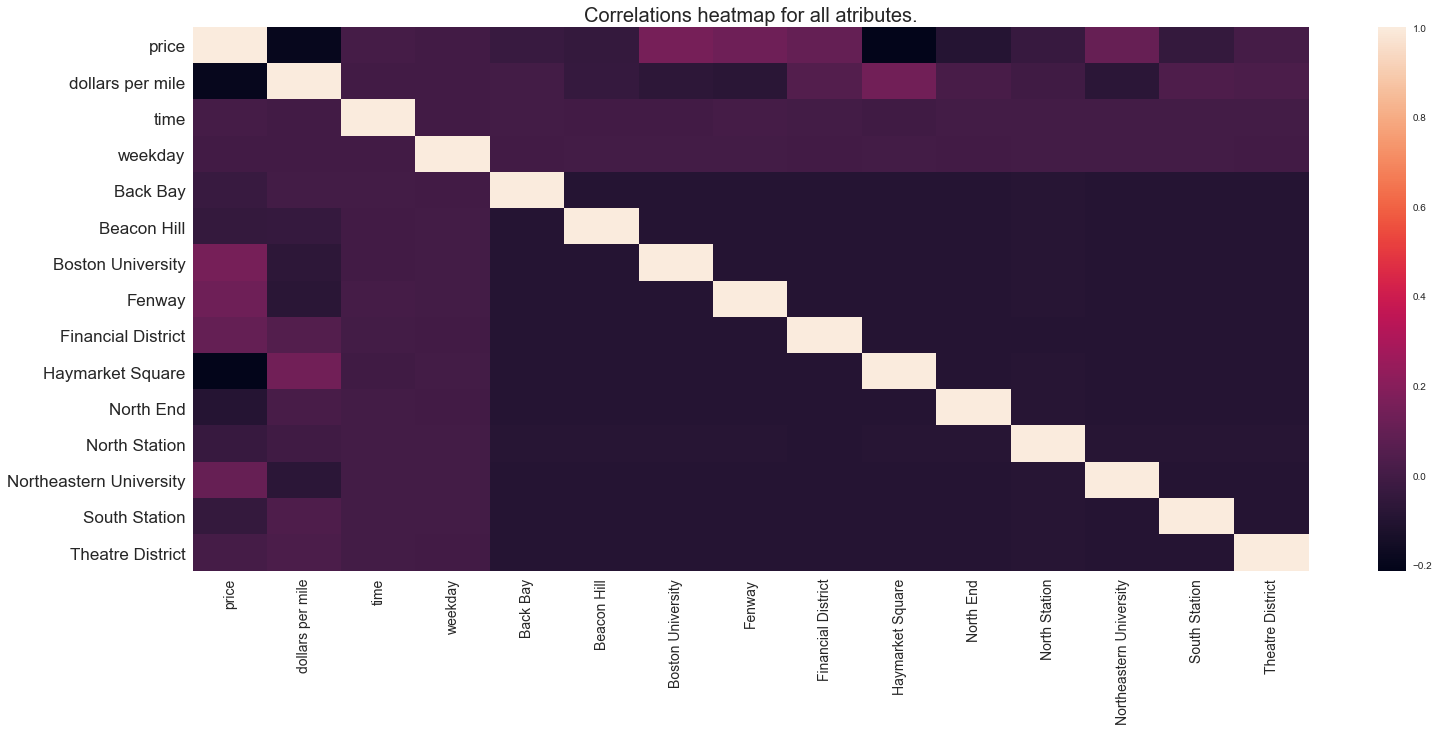

In [85]:
# Creating an object with the dummy variables for each source location
dummies = pd.get_dummies(rides['source'])
# Concatenating the rides dataframe object and the dummy object into a new one to be used for the OLS analysis only
rides_ols = pd.concat([rides,dummies], axis=1)
# Dropping one dummy column to avoid the dummy variable trap 
rides_ols.drop(['West End'], inplace=True, axis=1)

# Columns of interest in the regression and correlation analyis
filt1 = ['price','dollars per mile','time','weekday','Back Bay', 'Beacon Hill',
       'Boston University', 'Fenway', 'Financial District', 'Haymarket Square',
       'North End', 'North Station', 'Northeastern University',
       'South Station', 'Theatre District']
rides_ols_corr = rides_ols[filt1].corr()

# Plotting the correlations heatmap
plt.figure(figsize=((25,10)))
ax = sns.heatmap(rides_ols_corr)
plt.yticks(fontsize=17)
plt.xticks(fontsize=14)
plt.title('Correlations heatmap for all atributes.',fontsize=20)
plt.savefig('rides_corr.png',bbox_inches='tight')

plt.show()

### Predictive model of profitability based on location, time of day and weekday

In [62]:
from statsmodels.formula.api import ols

# Creating a filter to select the independent variables to take to OLS
filt = ['time','weekday','Back Bay', 'Beacon Hill',
       'Boston University', 'Fenway', 'Financial District', 'Haymarket Square',
       'North End', 'North Station', 'Northeastern University',
       'South Station', 'Theatre District']

# Defining the independent and the dependent variables
d = rides_ols['dollars per mile']
i = rides_ols[filt]

# Creasting and visualizing the model
profit_model = ols(formula="d~i",data=rides_ols).fit()
print(profit_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      d   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     331.8
Date:                Fri, 21 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:15:38   Log-Likelihood:            -3.4552e+05
No. Observations:              106329   AIC:                         6.911e+05
Df Residuals:                  106315   BIC:                         6.912e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5329      0.078     70.806      0.0

### Predictive model of profitability based on location

In [63]:
# Creating a filter to select the independent variables to take to OLS
filt = ['Back Bay','Beacon Hill','Boston University','Fenway','Financial District','Haymarket Square','North End','North Station','Northeastern University','South Station','Theatre District']

# Defining the independent and the dependent variables
d = rides_ols['dollars per mile']
i = rides_ols[filt]

# Creasting and visualizing the model
profit__location_model = ols(formula="d~i",data=rides_ols).fit()
print(profit__location_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      d   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     392.1
Date:                Fri, 21 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:15:38   Log-Likelihood:            -3.4552e+05
No. Observations:              106329   AIC:                         6.911e+05
Df Residuals:                  106317   BIC:                         6.912e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5011      0.066     82.866      0.0

### Predictive model of profitability based on time of day and weekday

In [64]:
# Creating a filter to select the independent variables to take to OLS
filt = ['time','weekday']

# Defining the independent and the dependent variables
d = rides_ols['dollars per mile']
i = rides_ols[filt]

# Creasting and visualizing the model
profit_time_model = ols(formula="d~i",data=rides_ols).fit()
print(profit_time_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      d   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8406
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.431
Time:                        15:15:38   Log-Likelihood:            -3.4764e+05
No. Observations:              106329   AIC:                         6.953e+05
Df Residuals:                  106326   BIC:                         6.953e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7112      0.046    123.115      0.0

### Insights from the predictive models
The summaries above show that it wasn't possible to develop any models to explain the variance of the profitability of Uber and Lyft's rides based on source location, hour of the day or weekday.  

The fact that a linear regression model couldn't be developed to explain profitability does not mean that the source of the ride, the weekday and the hour of the day do not affect Uber and Lyft rides. Other factors can explain the lack results, or it may simply be that the relationship between these factors is not linear. Therefore, efforts should be made to develop more complex algorithms to predict profitability and demand.

# Weather conditions and its influence on demand & profitability of Uber and Lyft rides
Another goal of this analysis was to understand how weather conditions affect demand and profitability for drivers.

The first step of the analysis is to clean the data and to analyse the distribution of the weather variables.

Next, it'll be performed an analysis of the distribution of weather measurements across time, to understand if the measurements were taken consistently across time. With the same goal, an analysis of the measurements across locations and understand if there are any inconsistencies (e.g. locations with visibly less measurements than the others).

Lastly, a regression analysis is performed to assess if it's possible to predict profitability and price based on weather variables.

# Cleaning the data
The analysis below shows that there are 5382 entries in the original weather dataset where rain is NA. However, since each column refers to an independent variable there's no reason to drop those entries.

In [65]:
print(raw_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperature  6276 non-null   float64       
 1   location     6276 non-null   object        
 2   clouds       6276 non-null   float64       
 3   pressure     6276 non-null   float64       
 4   rain         894 non-null    float64       
 5   timestamp    6276 non-null   datetime64[ns]
 6   humidity     6276 non-null   float64       
 7   wind         6276 non-null   float64       
 8   date         6276 non-null   object        
 9   time         6276 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 490.4+ KB
None


# Distribution of the weather data

The following distribution analysis shows that 'temperature', 'pressure' and 'wind' seem to be the only variables with enough variability to be useful in the analysis.

Since the data was collected in a short period of time (between 2018-11-26 and 2018-12-18), the concern was that there wouldn't be the significant change in weather conditions. The plots below confirm that scenario.

       temperature    clouds  pressure       rain  humidity      wind  \
count     6276.000  6276.000  6276.000  8.940e+02  6276.000  6276.000   
mean        39.090     0.678  1008.445  5.765e-02     0.764     6.803   
std          6.022     0.314    12.871  1.008e-01     0.127     3.633   
min         19.620     0.000   988.250  2.000e-04     0.450     0.290   
25%         36.078     0.440   997.747  4.900e-03     0.670     3.518   
50%         40.130     0.780  1007.660  1.485e-02     0.760     6.570   
75%         42.833     0.970  1018.480  6.092e-02     0.890     9.920   
max         55.410     1.000  1035.120  7.807e-01     0.990    18.180   

           time  
count  6276.000  
mean     10.583  
std       6.998  
min       0.000  
25%       5.000  
50%      10.000  
75%      17.000  
max      23.000  


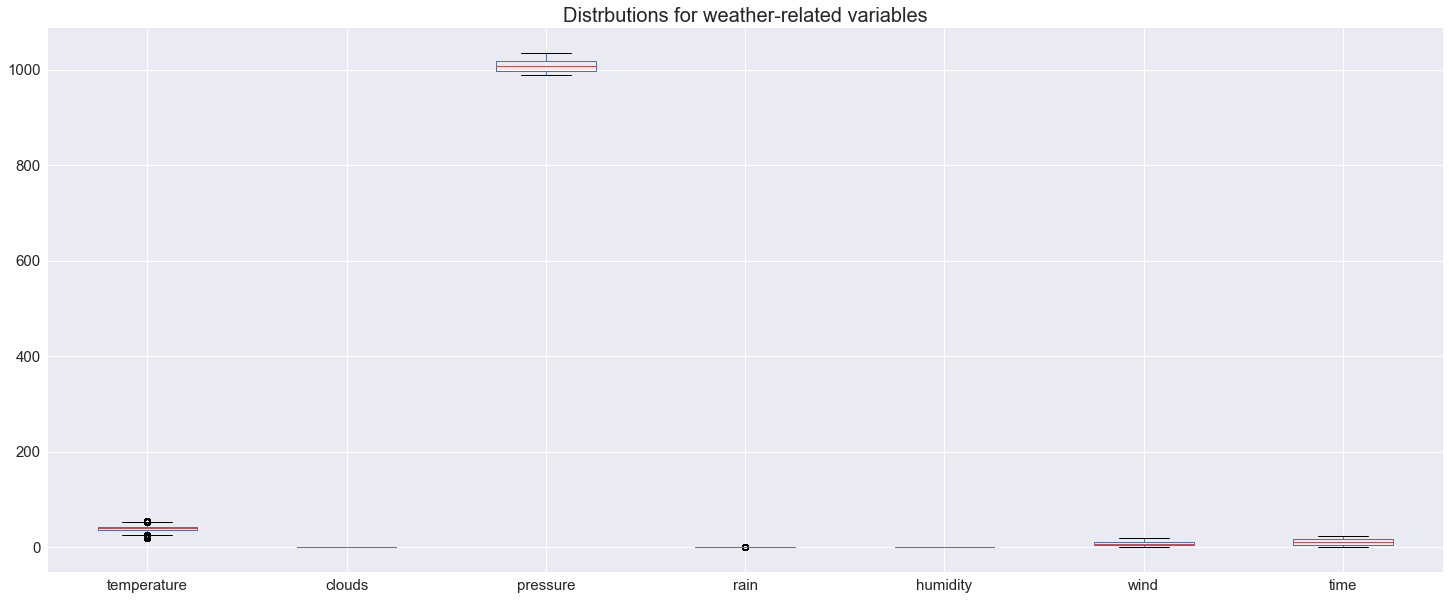

The 1st quartiles are:
temperature     36.078
clouds           0.440
pressure       997.747
rain             0.005
humidity         0.670
wind             3.518
time             5.000
Name: 0.25, dtype: float64
 
The 3rd quartiles are:
temperature      42.833
clouds            0.970
pressure       1018.480
rain              0.061
humidity          0.890
wind              9.920
time             17.000
Name: 0.75, dtype: float64
 
The IQRs are:
temperature     6.755
clouds          0.530
pressure       20.733
rain            0.056
humidity        0.220
wind            6.402
time           12.000
dtype: float64
 
The upper limits for outliers are:
temperature      52.965
clouds            1.765
pressure       1049.579
rain              0.145
humidity          1.220
wind             19.524
time             35.000
dtype: float64
 
The lower limits for outliers are:
temperature     25.945
clouds          -0.355
pressure       966.649
rain            -0.079
humidity         0.340
wind        

In [66]:
# Observing characteristics of the distribution of the numerical variables for the weather dataframe
print(raw_weather.describe())

# Visualizing the distribution of the same variables
raw_weather.boxplot(figsize=((25,10)),fontsize=15)
plt.title('Distrbutions for weather-related variables',fontsize=20)
plt.style.use('seaborn')

plt.show()

# Calculating IQR, as well as upper and lower limits for outliers in case it becomes necessary to remove them
iqr(raw_weather)

# Understanding the weather data
An initial look at the data made it clear that the timestamos of the data on weather conditions does not match the ones in the rides data.

The analysis below aims at understanding how does the timeline for the weather measurements look, and how to approach an analysis of this data.

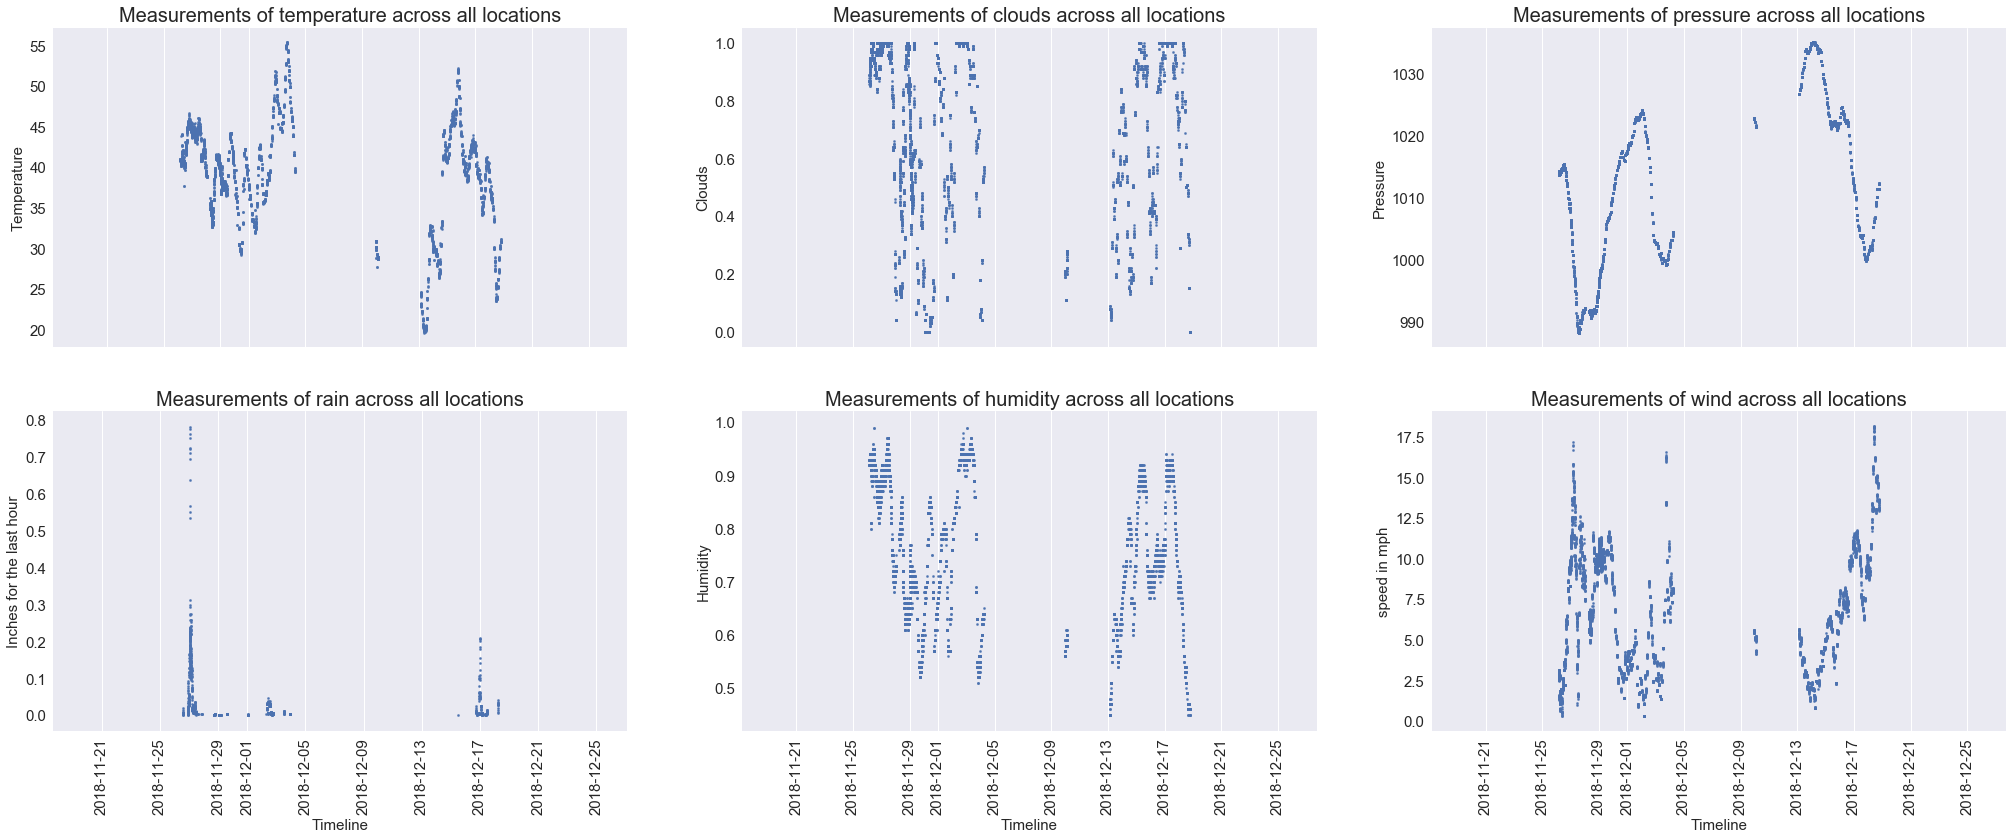

In [67]:
# Changing the name of the dataframe object, since there is no need to clean the data so far
weather = raw_weather
weather.set_index(weather['timestamp'],drop=False)

# Plotting the data on a scatterplot to take a high-level look at how it spreads through the timeline
plt.figure(figsize=((35,20)))
plt.grid(axis='y')

plt.subplot(3,3,1)
plt.scatter(weather['timestamp'],weather['temperature'],s=5)
plt.xticks(color='white')
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Temperature',fontsize=15)
plt.title('Measurements of temperature across all locations',fontsize=20)
plt.grid(axis='y')

plt.subplot(3,3,2)
plt.scatter(weather['timestamp'],weather['clouds'],s=5)
plt.xticks(color='white')
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Clouds',fontsize=15)
plt.title('Measurements of clouds across all locations',fontsize=20)
plt.grid(axis='y')

plt.subplot(3,3,3)
plt.scatter(weather['timestamp'],weather['pressure'],s=5)
plt.xticks(color='white')
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Pressure',fontsize=15)
plt.title('Measurements of pressure across all locations',fontsize=20)
plt.grid(axis='y')

plt.subplot(3,3,4)
plt.scatter(weather['timestamp'],weather['rain'],s=5)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Timeline',fontsize=15)
plt.ylabel('Inches for the last hour',fontsize=15)
plt.title('Measurements of rain across all locations',fontsize=20)
plt.grid(axis='y')

plt.subplot(3,3,5)
plt.scatter(weather['timestamp'],weather['humidity'],s=5)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Timeline',fontsize=15)
plt.ylabel('Humidity',fontsize=15)
plt.title('Measurements of humidity across all locations',fontsize=20)
plt.grid(axis='y')

plt.subplot(3,3,6)
plt.scatter(weather['timestamp'],weather['wind'],s=5)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Timeline',fontsize=15)
plt.ylabel('speed in mph',fontsize=15)
plt.title('Measurements of wind across all locations',fontsize=20)
plt.grid(axis='y')

plt.show()

In [68]:
# The plots above show clearly that there are periods in between the timeline when no measurements were taken.
# Those periods are identified below
print(weather[(weather['timestamp'] >= '2018-12-05') & (weather['timestamp'] <= '2018-12-08')])
print(weather[(weather['timestamp'] >= '2018-12-11') & (weather['timestamp'] <= '2018-12-12')])

Empty DataFrame
Columns: [temperature, location, clouds, pressure, rain, timestamp, humidity, wind, date, time]
Index: []
Empty DataFrame
Columns: [temperature, location, clouds, pressure, rain, timestamp, humidity, wind, date, time]
Index: []


### Note about the weather measurements
The boxplots above makes it clear that the weather measurements weren't taken at regular intervals. It's also clear that there is a visible absence of measurements for periods of more that one day - so in those intervals, no weather analysis is possible.

Below the boxplots, it's indentified the time periods in between this dataset when no measurements were made.

# Do the weather measurements differ between locations? 
The following analysis were performed to understand if the frequency and quantity of weather measurements differs between locations. 

No visible differences between all locations stand out, considering the amount of measurements for each variable and the distribution of the values in the swarplots.

The exception is the variable 'rain' which as it was already mentioned has several NaN's, and slight differences between the count fo measurements per location.

C:\Users\Utilizador\anaconda3\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Utilizador\anaconda3\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


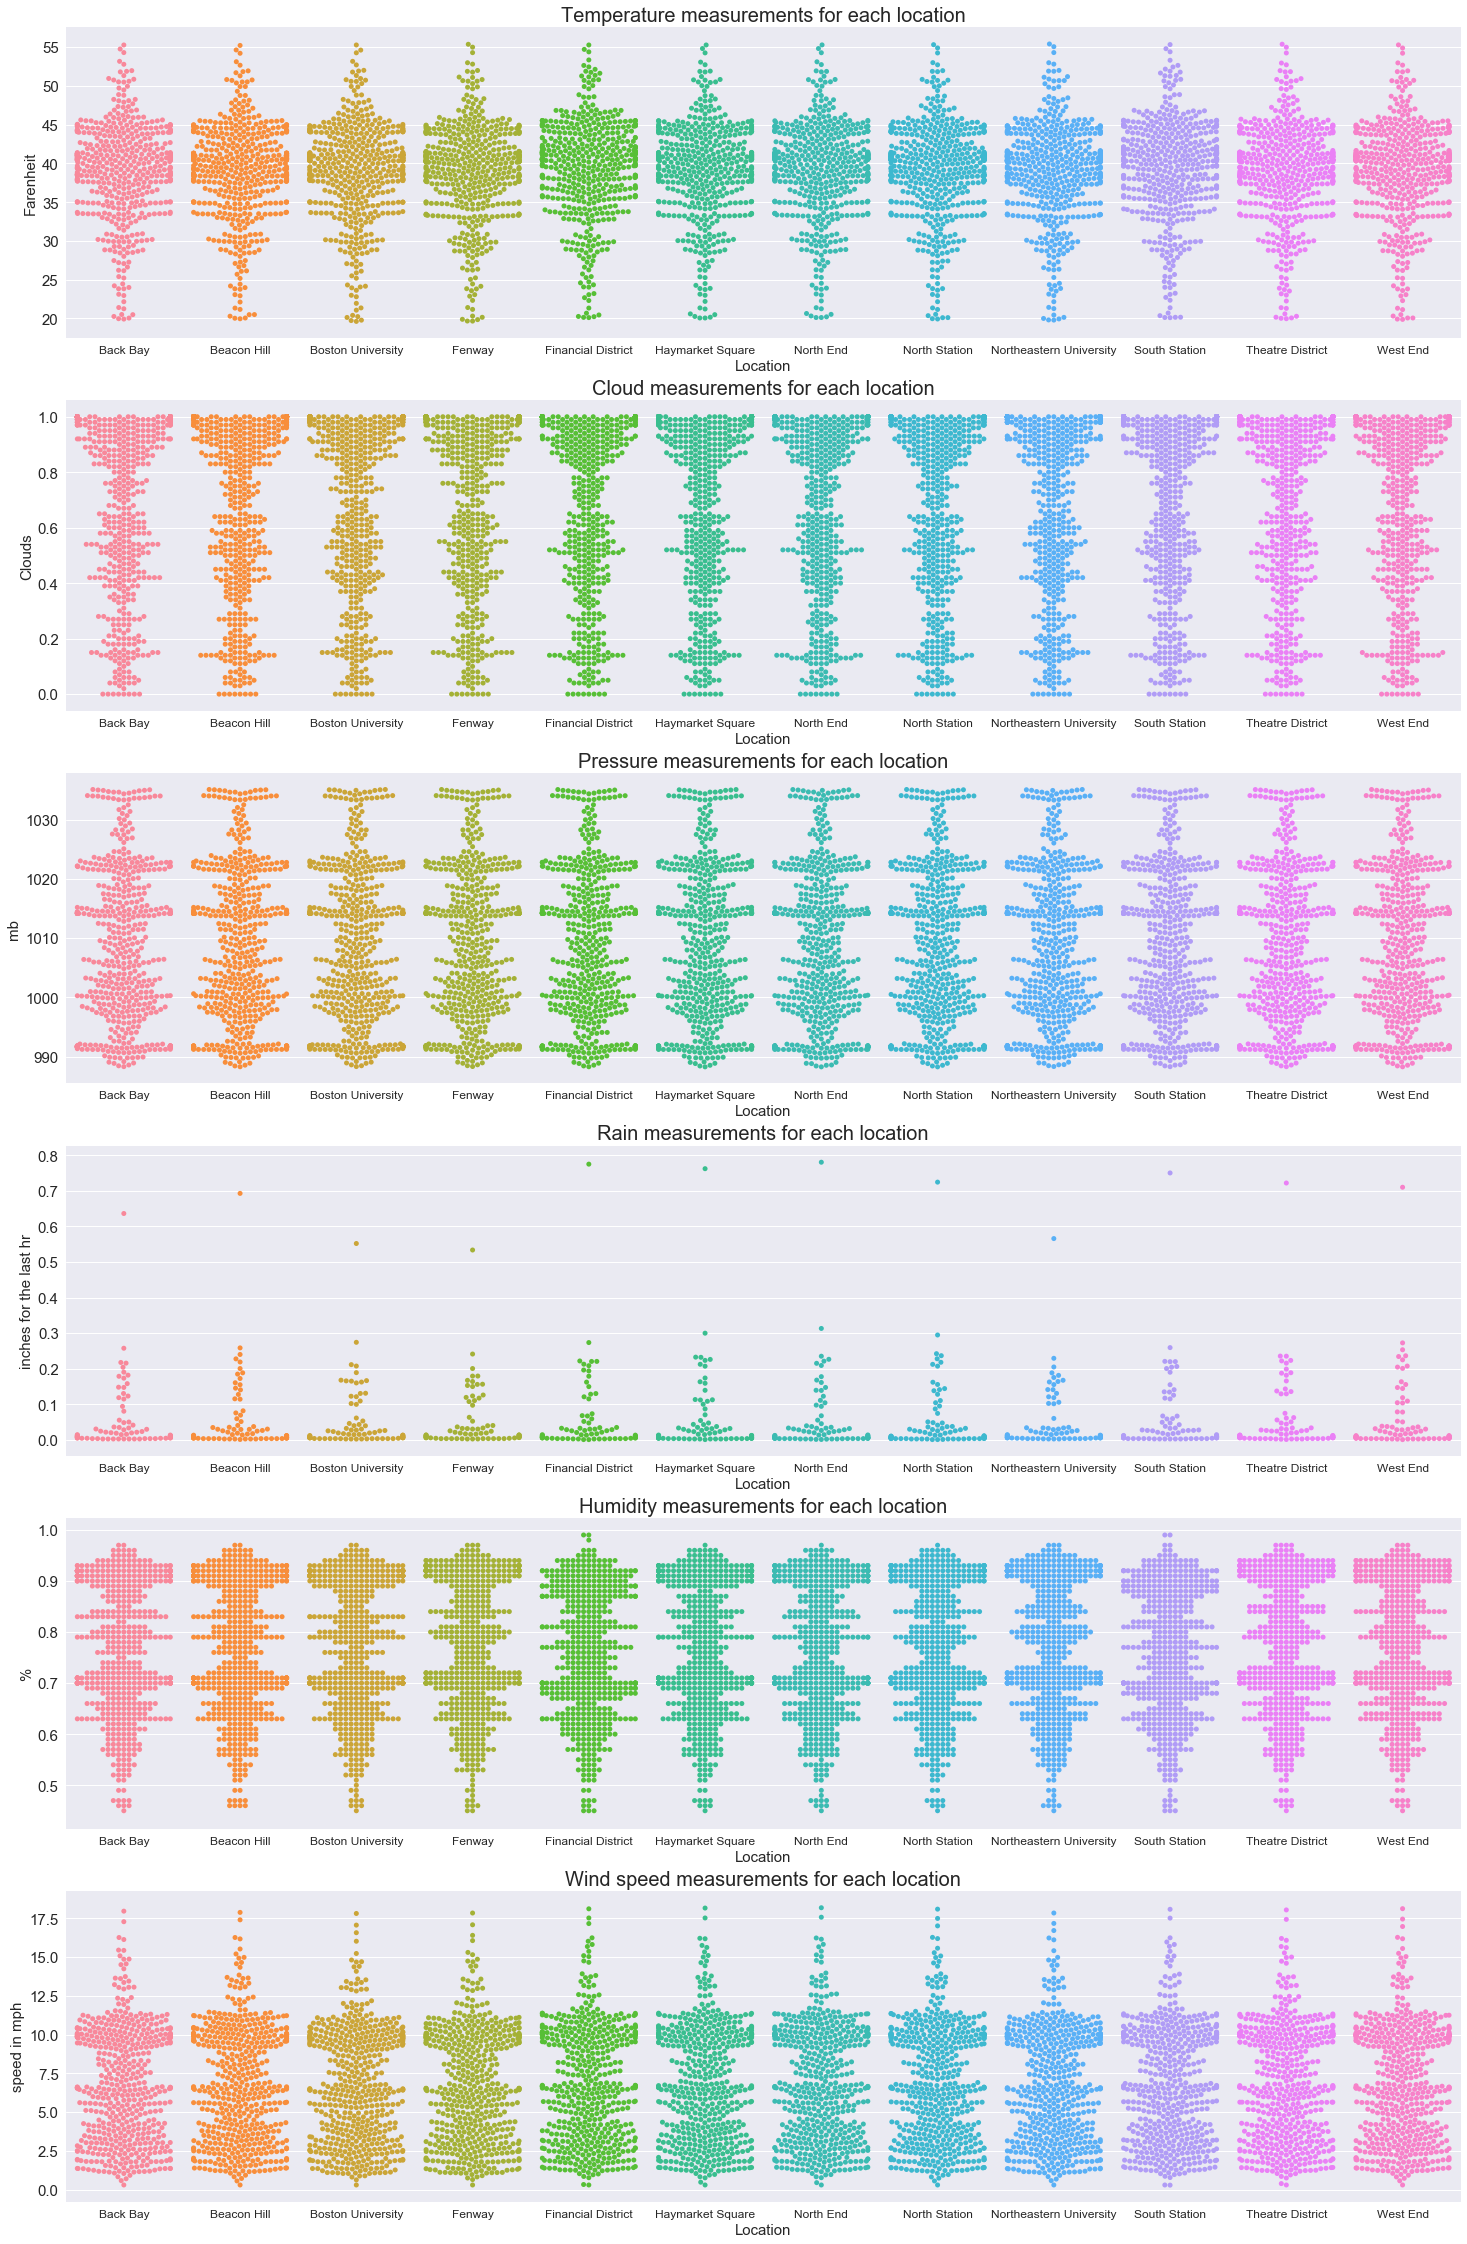

In [69]:
plt.figure(figsize=((25,40)))

# Plotting temperature per location
plt.subplot(6,1,1)
sns.swarmplot(x='location',y='temperature',data=weather,size=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Location',fontsize=15)
plt.ylabel('Farenheit',fontsize=15)
plt.title('Temperature measurements for each location',fontsize=20)

# Plotting clouds per location
plt.subplot(6,1,2)
sns.swarmplot(x='location',y='clouds',data=weather,size=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Location',fontsize=15)
plt.ylabel('Clouds',fontsize=15)
plt.title('Cloud measurements for each location',fontsize=20)

# Plotting pressure per location
plt.subplot(6,1,3)
sns.swarmplot(x='location',y='pressure',data=weather,size=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Location',fontsize=15)
plt.ylabel('mb',fontsize=15)
plt.title('Pressure measurements for each location',fontsize=20)

# Plotting rain per location
plt.subplot(6,1,4)
sns.swarmplot(x='location',y='rain',data=weather,size=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Location',fontsize=15)
plt.ylabel('inches for the last hr',fontsize=15)
plt.title('Rain measurements for each location',fontsize=20)

# Plotting humidity per location
plt.subplot(6,1,5)
sns.swarmplot(x='location',y='humidity',data=weather,size=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Location',fontsize=15)
plt.ylabel('%',fontsize=15)
plt.title('Humidity measurements for each location',fontsize=20)

# Plotting wind speed per location
plt.subplot(6,1,6)
sns.swarmplot(x='location',y='wind',data=weather,size=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Location',fontsize=15)
plt.ylabel('speed in mph',fontsize=15)
plt.title('Wind speed measurements for each location',fontsize=20)

plt.show()


# Goal 3: Predicting demand and profitability based on weather conditions
The major goal of using weather conditions was understanding if it was possible to develop a predictive model of price of rides and their profitability based on weather conditions. That analysis was implemented below.

To do so, it was necessary to merge the weather data with the rides data. Since they couldn't be matched on theur timestamps (because there is no need to have the weather conditions on the second the ride started, nor does that information exist for most rides), it was required to reformat weather information to a  higher-level. Ideally this would have been done using rolling mean, but that wasn't possible because of weather measurements were taken at irregular intervals. Therefore, the solution was to group the weather data by location, day and hour, and match to each ride the mean weather conditions at each hour of each day, in each specific source location. 

In [70]:
# Create a field with date, time and location for rides. 
# This is the field where weather and rides data will be merged on.
rides['date_loc'] = rides['source'].astype(str)+', '+rides['date'].astype(str)+', '+rides['time'].astype(str)

# Grouping weather information by location, date and time.
weather_merge = weather.groupby(['location','date','time']).mean()
weather_merge = pd.DataFrame(weather_merge).reset_index()
# Create a field with date, time and location for weather. 
weather_merge['date_loc'] = weather_merge['location'].astype(str)+', '+weather_merge['date'].astype(str)+', '+weather_merge['time'].astype(str)
weather_merge.index = weather_merge['date_loc']

# Merging the rides and the weather dataframes
merged = rides.join(weather_merge,on=['date_loc'],rsuffix='_wthr')
merged['rain'].fillna(0,inplace=True)

# Making sure that there is no ride without weather info, and vice-versa
merged = merged[pd.notnull(merged['price'])]
merged = merged[pd.notnull(merged['date_loc_wthr'])]

# Resetting the index
merged.reset_index(inplace=True,drop=True)

C:\Users\Utilizador\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Goal 3A: Predicting demand for rides based on weather conditions
The analysis below shows how demand (in this case measured only through aggregated revenues) varies with weather conditions.


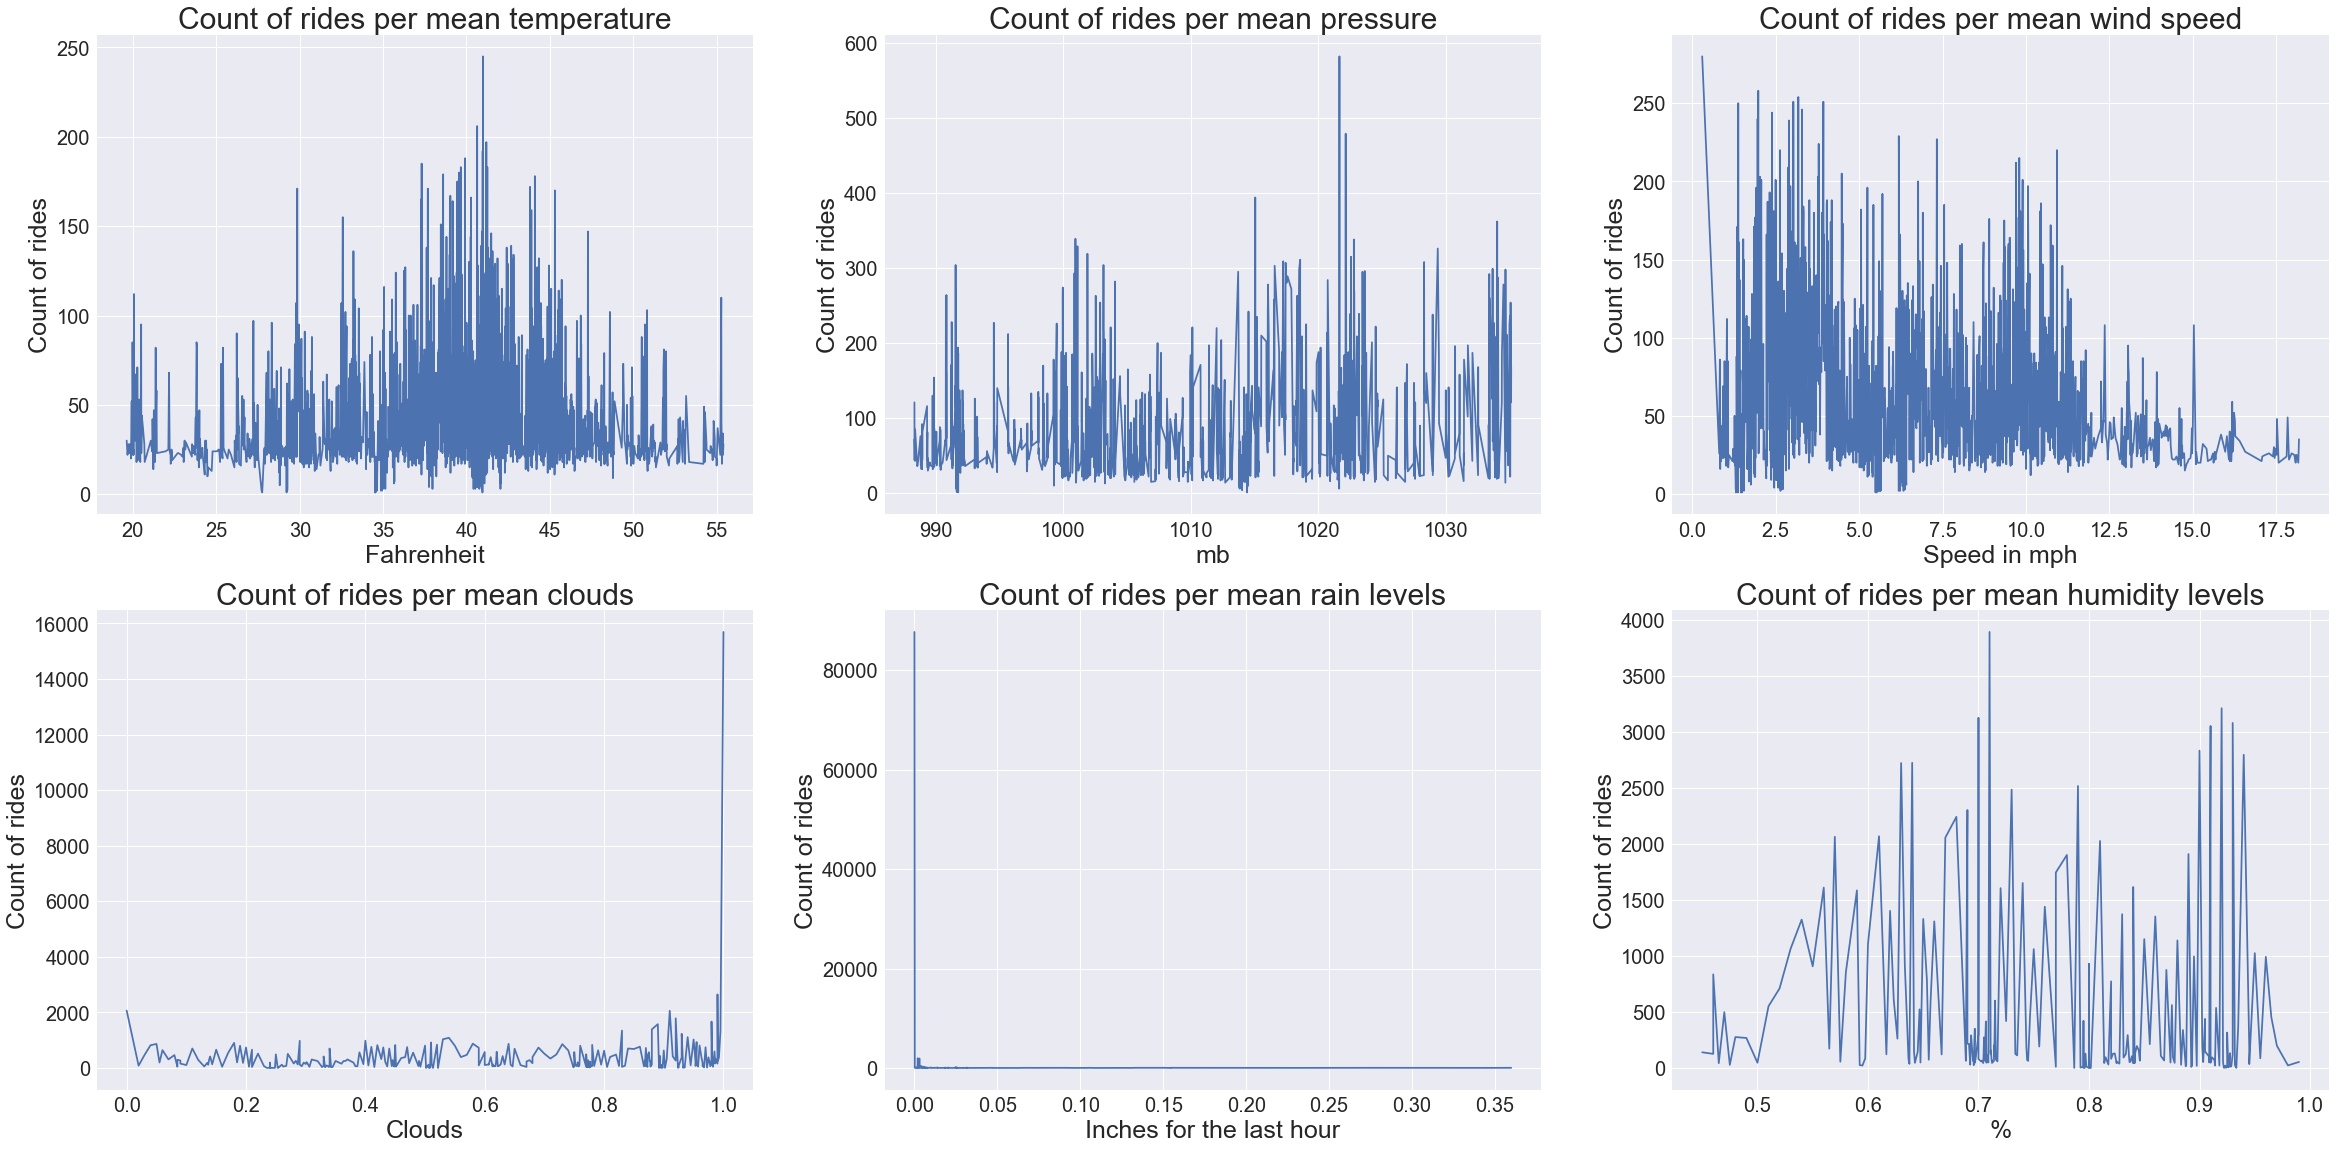

In [71]:
# Setting figure size
plt.figure(figsize=((40,30)))

# Plotting average daily temperature
plt.subplot(3,3,1)
merged.groupby('temperature')['ride_id'].count().plot()
plt.title('Count of rides per mean temperature',fontsize=30)
plt.xlabel('Fahrenheit',fontsize=25)
plt.ylabel('Count of rides',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily pressure
plt.subplot(3,3,2)
merged.groupby('pressure')['ride_id'].count().plot()
plt.title('Count of rides per mean pressure',fontsize=30)
plt.xlabel('mb',fontsize=25)
plt.ylabel('Count of rides',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily wind speed
plt.subplot(3,3,3)
merged.groupby('wind')['ride_id'].count().plot()
plt.title('Count of rides per mean wind speed',fontsize=30)
plt.xlabel('Speed in mph',fontsize=25)
plt.ylabel('Count of rides',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily clouds
plt.subplot(3,3,4)
merged.groupby('clouds')['ride_id'].count().plot()
plt.title('Count of rides per mean clouds',fontsize=30)
plt.xlabel('Clouds',fontsize=25)
plt.ylabel('Count of rides',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily rain
plt.subplot(3,3,5)
merged.groupby('rain')['ride_id'].count().plot()
plt.title('Count of rides per mean rain levels',fontsize=30)
plt.xlabel('Inches for the last hour',fontsize=25)
plt.ylabel('Count of rides',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily humidity
plt.subplot(3,3,6)
merged.groupby('humidity')['ride_id'].count().plot()
plt.title('Count of rides per mean humidity levels',fontsize=30)
plt.xlabel('%',fontsize=25)
plt.ylabel('Count of rides',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

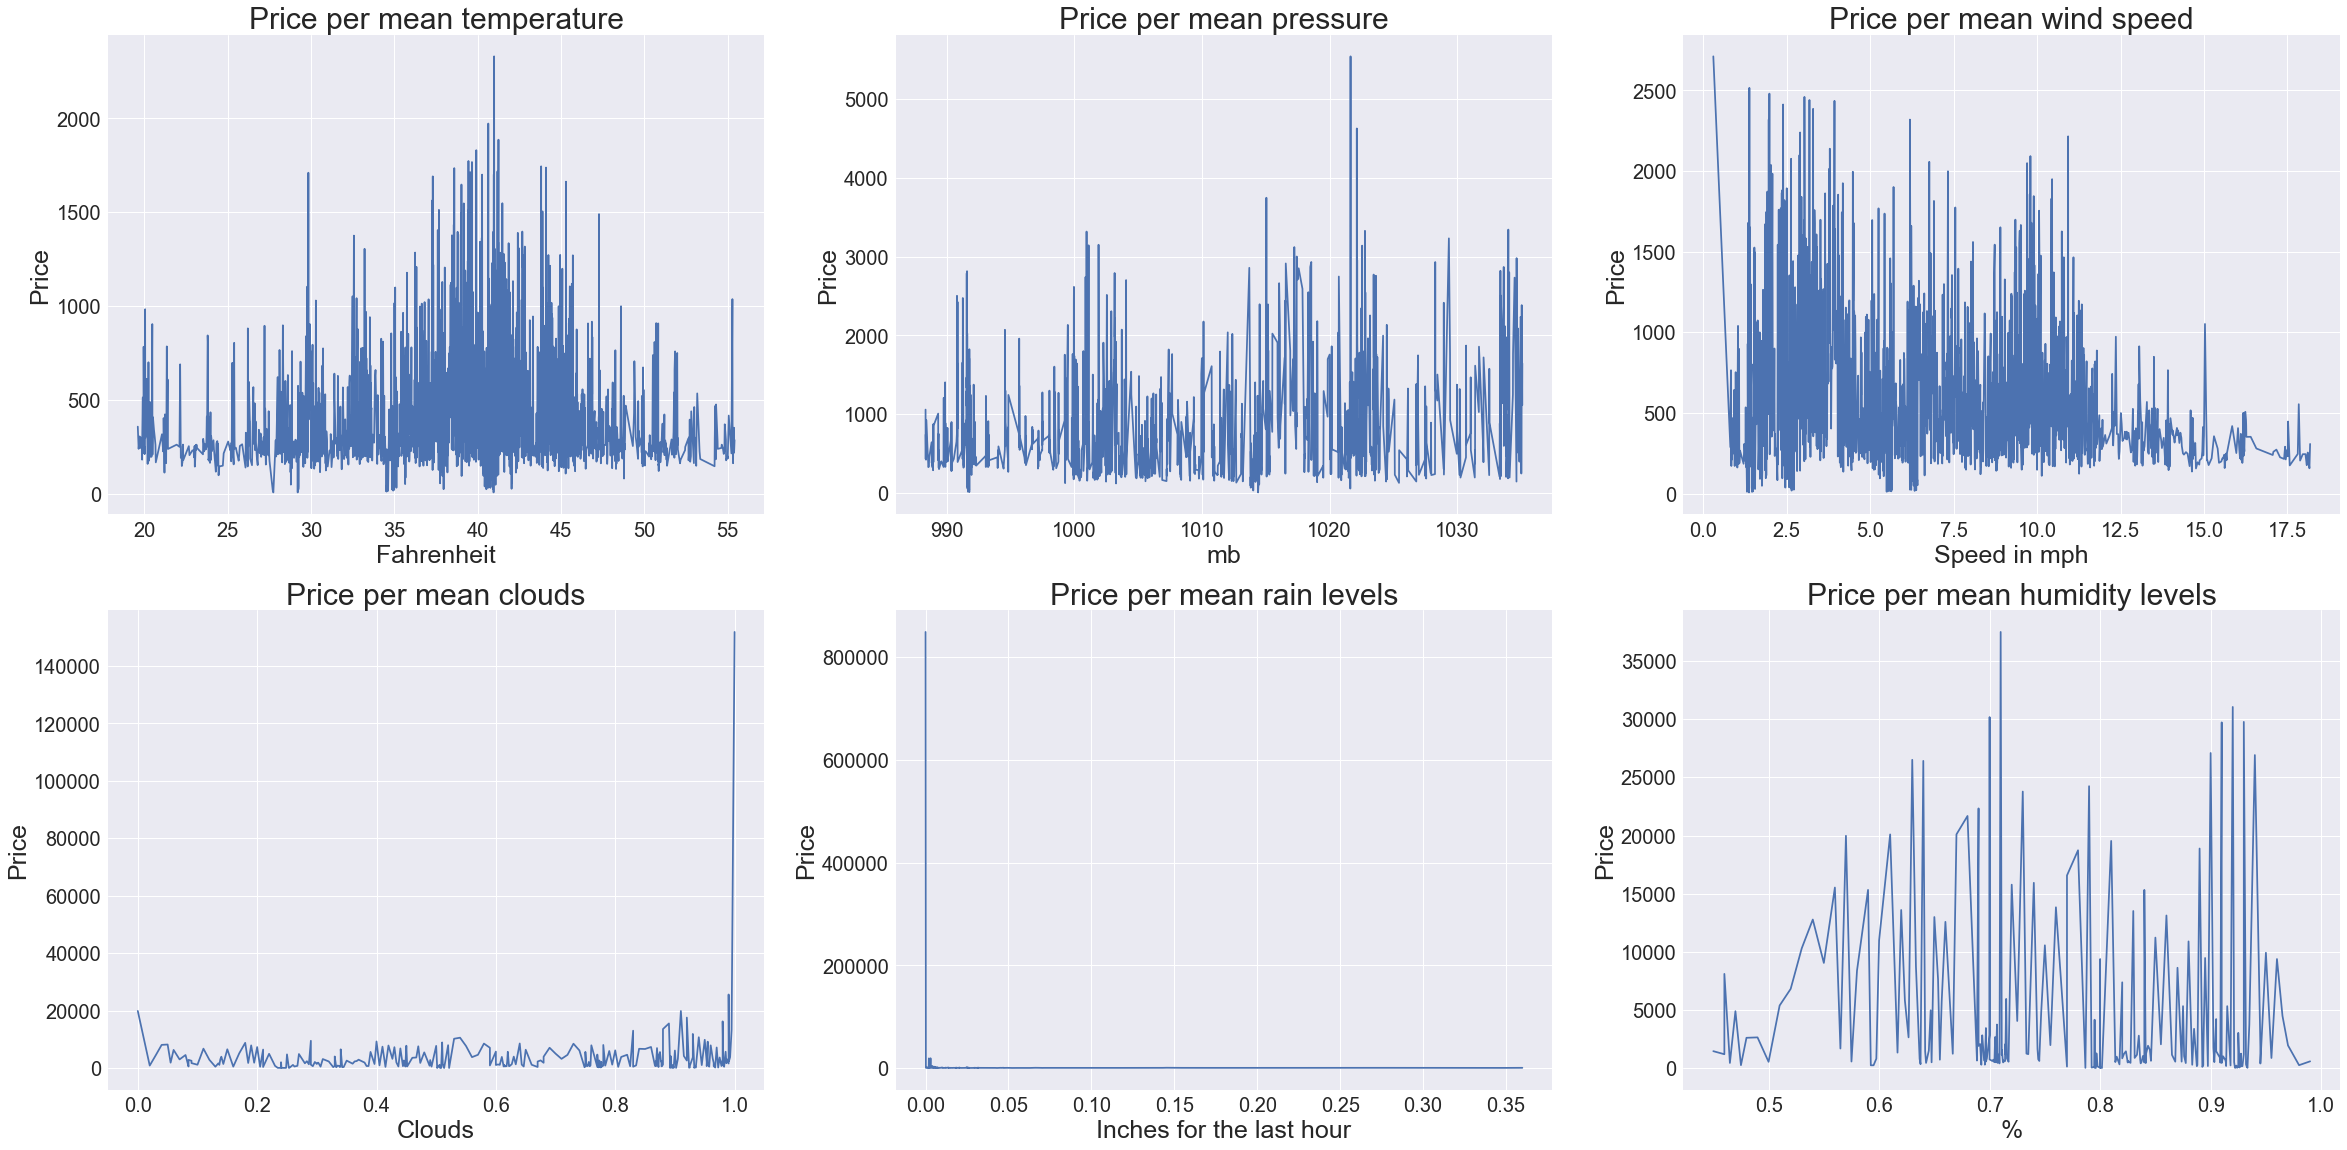

In [72]:
# Setting figure size
plt.figure(figsize=((40,30)))

# Plotting average daily temperature
plt.subplot(3,3,1)
merged.groupby('temperature')['price'].sum().plot()
plt.title('Price per mean temperature',fontsize=30)
plt.xlabel('Fahrenheit',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily pressure
plt.subplot(3,3,2)
merged.groupby('pressure')['price'].sum().plot()
plt.title('Price per mean pressure',fontsize=30)
plt.xlabel('mb',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily wind speed
plt.subplot(3,3,3)
merged.groupby('wind')['price'].sum().plot()
plt.title('Price per mean wind speed',fontsize=30)
plt.xlabel('Speed in mph',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily clouds
plt.subplot(3,3,4)
merged.groupby('clouds')['price'].sum().plot()
plt.title('Price per mean clouds',fontsize=30)
plt.xlabel('Clouds',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily rain
plt.subplot(3,3,5)
merged.groupby('rain')['price'].sum().plot()
plt.title('Price per mean rain levels',fontsize=30)
plt.xlabel('Inches for the last hour',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plotting average daily humidity
plt.subplot(3,3,6)
merged.groupby('humidity')['price'].sum().plot()
plt.title('Price per mean humidity levels',fontsize=30)
plt.xlabel('%',fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

### Insights on demand and weather conditions
It's difficult to obtain clear insights about relationships between weather conditions and demand. For most variables, demand doesn't seem to change accordingly. The exceptions are 'temperature', 'pressure' and 'humidity'. 

Regarding temperature, between 35 and 45 degrees Fahrenheit the aggregated revenue for Uber and Lyft rides is at it's highest, reaching the highest point of 2330.5$ between 40 and 41 degrees Fahrenheit.

As for pressure, there is a peak in revenue (5543.5$) at around 1021mb.

As for humidity levels, demand seems the highest when humidity measures around 0.7% and revenue reaches 37,501 dollars. Also, there's an interval between 0.90% and 0.94% where revenue increases and reaches 31,053 dollars.

# Goal 3B: predicting profitability based on weather conditions 
## An initial look
Before attempting to predict ride profitability based on weather conditions, an initial look was taken to understand if there was any potential for a relationship between weather and profitability of the rides.

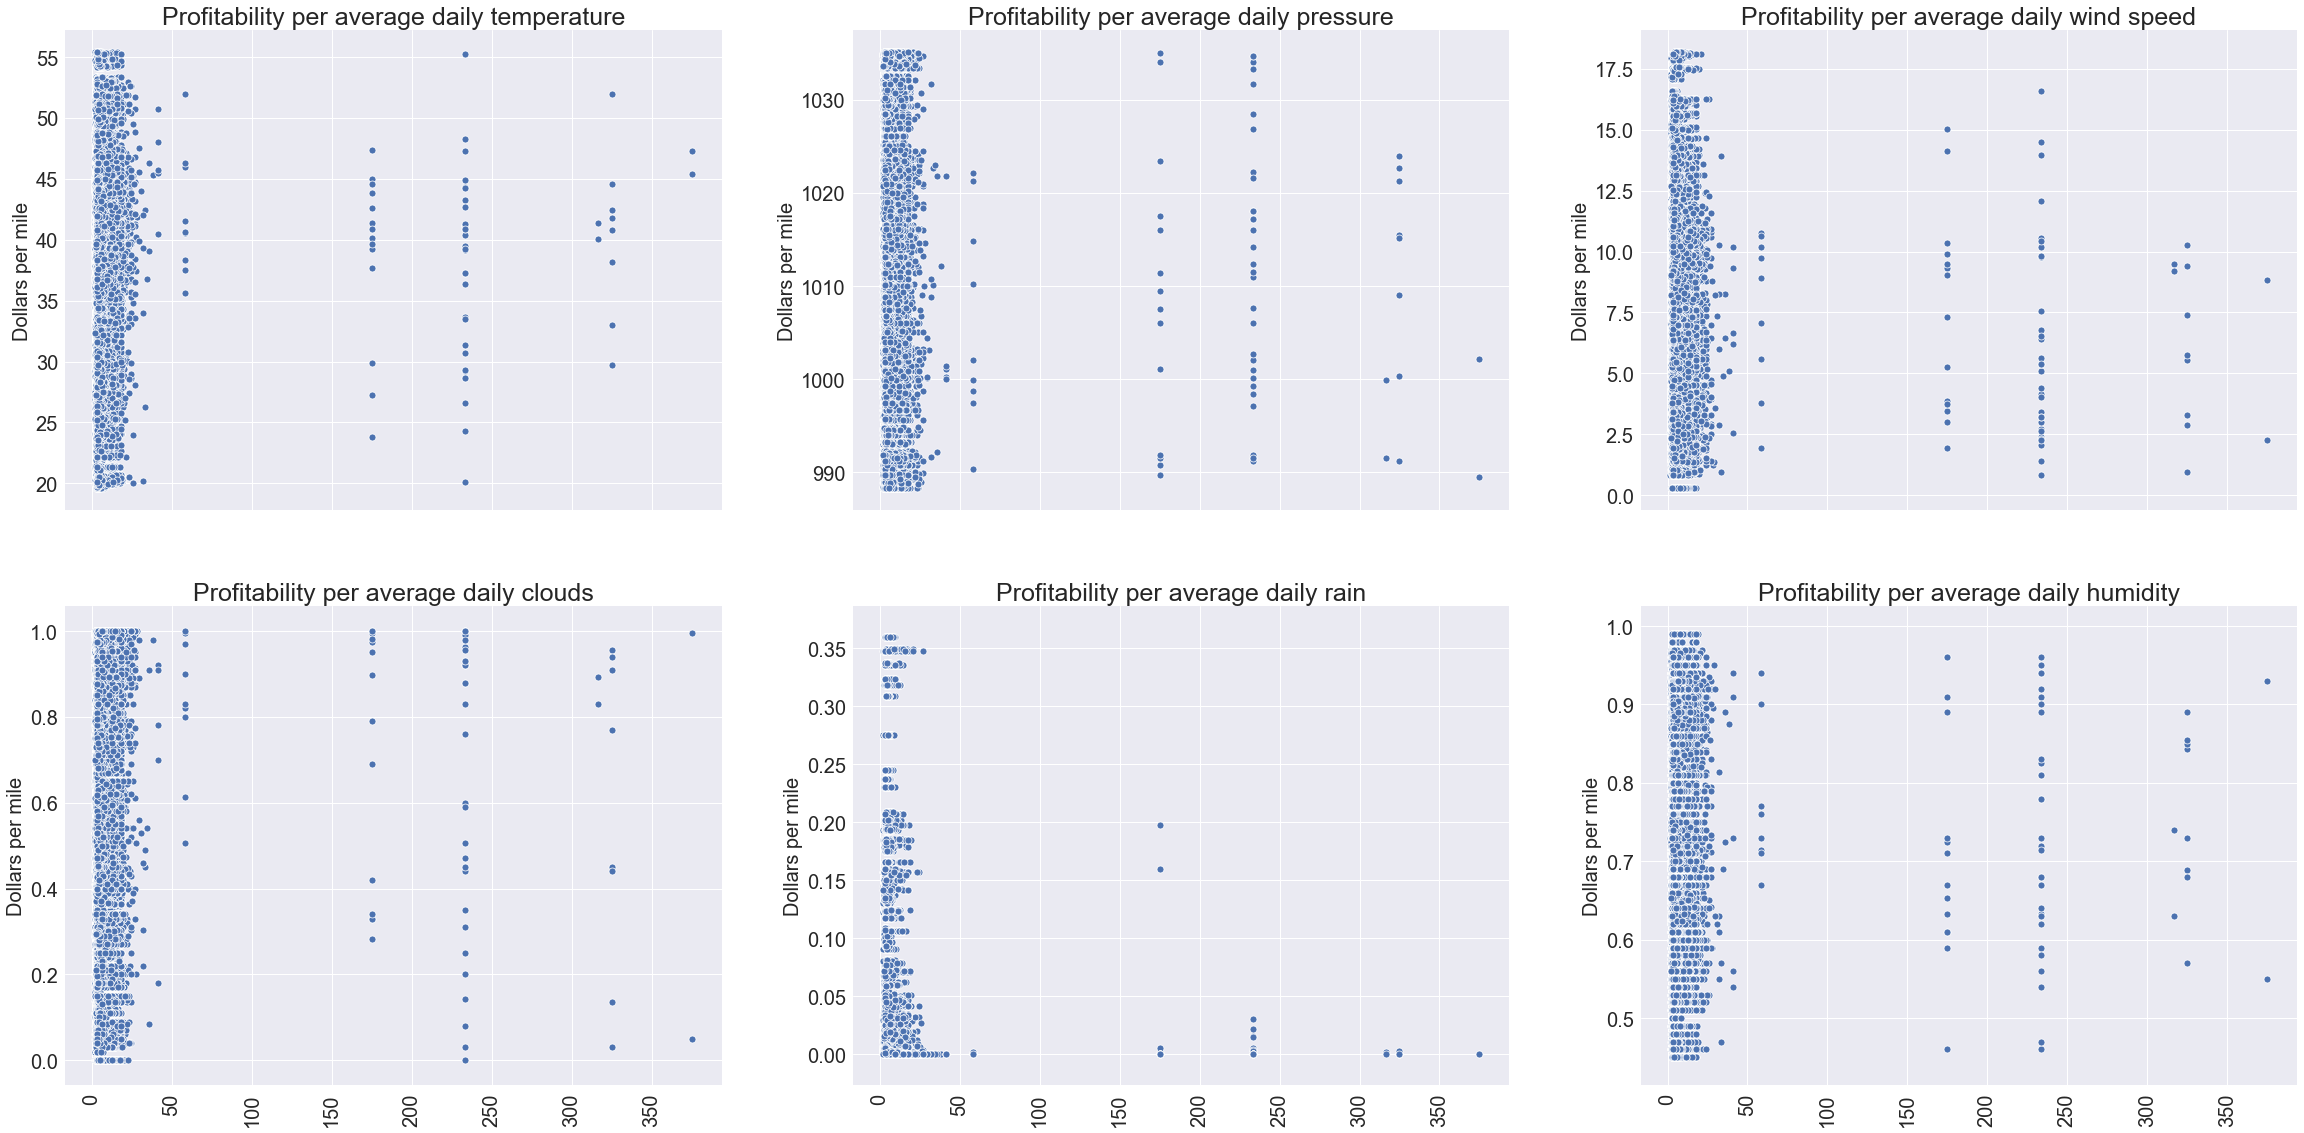

In [73]:
# Setting figure size
plt.figure(figsize=((40,30)))

# Plotting average daily temperature
plt.subplot(3,3,1)
sns.scatterplot(x='dollars per mile',y='temperature',data=merged)
plt.title('Profitability per average daily temperature',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=20)
plt.xlabel('')
plt.yticks(fontsize=20)
plt.xticks(color='white')

# Plotting average daily pressure
plt.subplot(3,3,2)
sns.scatterplot(x='dollars per mile',y='pressure',data=merged)
plt.title('Profitability per average daily pressure',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=20)
plt.xlabel('')
plt.yticks(fontsize=20)
plt.xticks(color='white')

# Plotting average daily wind speed
plt.subplot(3,3,3)
sns.scatterplot(x='dollars per mile',y='wind',data=merged)
plt.title('Profitability per average daily wind speed',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=20)
plt.xlabel('')
plt.yticks(fontsize=20)
plt.xticks(color='white')

# Plotting average daily clouds
plt.subplot(3,3,4)
sns.scatterplot(x='dollars per mile',y='clouds',data=merged)
plt.title('Profitability per average daily clouds',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=20)
plt.xlabel('')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation=90)

# Plotting average daily rain
plt.subplot(3,3,5)
sns.scatterplot(x='dollars per mile',y='rain',data=merged)
plt.title('Profitability per average daily rain',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=20)
plt.xlabel('')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation=90)

# Plotting average daily humidity
plt.subplot(3,3,6)
sns.scatterplot(x='dollars per mile',y='humidity',data=merged)
plt.title('Profitability per average daily humidity',fontsize=25)
plt.ylabel('Dollars per mile',fontsize=20)
plt.xlabel('')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation=90)

plt.show()

### Insights
Looking at the scatterplots above, there seems to be no visible relationship between profitability and any weather variable. This suggests that it is very unlikely that a predictive model of profitability can be developed from this variables.

# Correlations heatmap

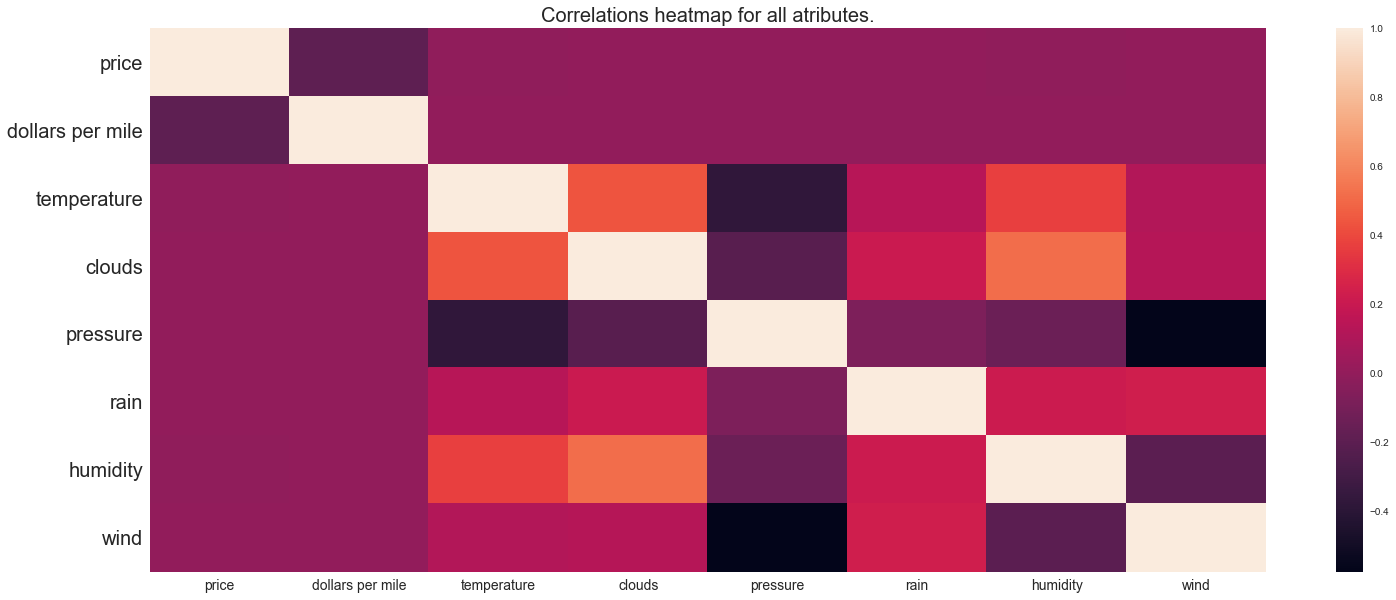

In [74]:
# Before running the regression analysis, it's useful to look at correlations first 
# to identify potential predictors.

# Columns of interest in the regression and correlation analyis
filt4 = ['price','dollars per mile','location','temperature','clouds','pressure','rain','humidity','wind']
merged_corr = merged[filt4].corr()

# Plotting the correlations heatmap
plt.figure(figsize=((25,10)))
ax = sns.heatmap(merged_corr)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title('Correlations heatmap for all atributes.',fontsize=20)
plt.savefig('rides_weather_corr.png',bbox_inches='tight')

plt.show()

### Insights from the correlations 
Looking at the heatmap above, there isn't any correlation between profitability or price and any weather variable. This suggests that it is very unlikely that a predictive model of profitability can be developed from this variables.

# Regressive model to predict ride profitability
Based on the absence of correlations between profitability and all weather variables, it's very unlikely that any predictive model of profitability can be developed based on this variables. Still, for the sake of the project, below is the attempt at developing a model.

In [75]:
# Creating a filter to select the independent variables to take to OLS
filt5 = ['temperature','clouds','pressure','rain','humidity','wind']

# Defining the independent and the dependent variables. The filter column is the same as above
d = merged['dollars per mile']
i = merged[filt5]

# Creasting and visualizing the model
weather_profit_model = ols(formula="d~i",data=merged).fit()
print(weather_profit_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      d   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7599
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.601
Time:                        15:16:04   Log-Likelihood:            -3.4627e+05
No. Observations:              105856   AIC:                         6.925e+05
Df Residuals:                  105849   BIC:                         6.926e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7113      2.156      3.576      0.0

### Regressive model to predict ride price

In [76]:
# Defining the independent and the dependent variables
d = merged['price']
i = merged[filt5]

# Creasting and visualizing the model
weather_price_model = ols(formula="d~i",data=merged).fit()
print(weather_price_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      d   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8040
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.567
Time:                        15:16:04   Log-Likelihood:            -2.4711e+05
No. Observations:              105856   AIC:                         4.942e+05
Df Residuals:                  105849   BIC:                         4.943e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2188      0.845     12.091      0.0

### Insights from the regression analysis
As predicted, it was not possible to develop models to explain the variance of price or profitability based on weather variables. In the same line, weather variables don't seem related with demand as measured by aggregated revenues.

The fact that a linear regression model couldn't be developed to explain profitability does not mean that the weather conditions do not affect Uber and Lyft rides. Other factors can explain the lack results, or it may simply be that the relationship between these factors is not linear. Therefore, efforts should be made to develop more complex algorithms to predict profitability and demand.